In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import pytz

# Read the list of filenames from the configuration file
with open('file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'

# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = "data\\"+file
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])

In [2]:
data['date'] = pd.to_datetime(data['date'])

In [3]:
def convert_utc_to_cet(df, date_column='date'):
    """
    Convert UTC timestamps to Central European Time (CET/CEST) with proper DST handling
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the date column
    date_column (str): Name of the column containing UTC timestamps
    
    Returns:
    pd.DataFrame: DataFrame with converted timestamps
    """
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Ensure timestamps are UTC aware
    if df[date_column].dt.tz is None:
        df[date_column] = df[date_column].dt.tz_localize('UTC')
    elif df[date_column].dt.tz != pytz.UTC:
        df[date_column] = df[date_column].dt.tz_convert('UTC')
    
    # Convert to CET/CEST (Europe/Berlin includes proper DST handling)
    df[date_column] = df[date_column].dt.tz_convert('Europe/Berlin')
    
    return df


In [4]:
data = convert_utc_to_cet(data)

In [5]:
data.shape

(1081746, 4)

In [6]:
#first messege for each user
data['first_message'] = data.groupby('user').cumcount().apply(lambda x: 1 if x == 0 else 0)

In [7]:
#unique chaterrs each stream
unique_chatters_per_stream = data.groupby('stream')['user'].nunique()

In [8]:
message_per_stream = data.groupby('stream')["message"].count()

In [9]:
# Calculate the number of first messages per stream
first_messages_per_stream = data.groupby('stream')['first_message'].sum()


# Calculate the total number of messages per stream
total_messages_per_stream = data['stream'].value_counts()

# Combine the results into a single DataFrame
stream_stats = pd.DataFrame({
    'first_messages': first_messages_per_stream,
    'total_messages': total_messages_per_stream,
    'unique_chatters': unique_chatters_per_stream,
    'message_count': message_per_stream
})

# Calculate the time difference between the first and last messages for each stream
stream_lengths = data.groupby('stream')['date'].agg(lambda x: (x.max() - x.min()).total_seconds())

# Add the stream_length column to the stream_stats DataFrame
stream_stats['stream_length'] = stream_lengths

#stream length pre hour
stream_stats['stream_length_hour'] = stream_stats['stream_length'] /60 /60

#stream length per firt
stream_stats['stream_length_per_firt'] = stream_stats['first_messages'] / stream_stats['stream_length_hour'] 

#unique chatters per hour
stream_stats['unique_chatters_per_hour'] = stream_stats['unique_chatters'] / stream_stats['stream_length_hour']

#messages per hour
stream_stats['message_per_min'] = stream_stats['message_count'] / stream_stats['stream_length_hour'] /60


In [10]:
# Calculate mean of first messages
mean_first_messages = stream_stats['first_messages'].mean()

stream_stats['first_messages_avg'] = stream_stats['first_messages'].expanding().mean()

# Bar positions
index = range(len(stream_stats))

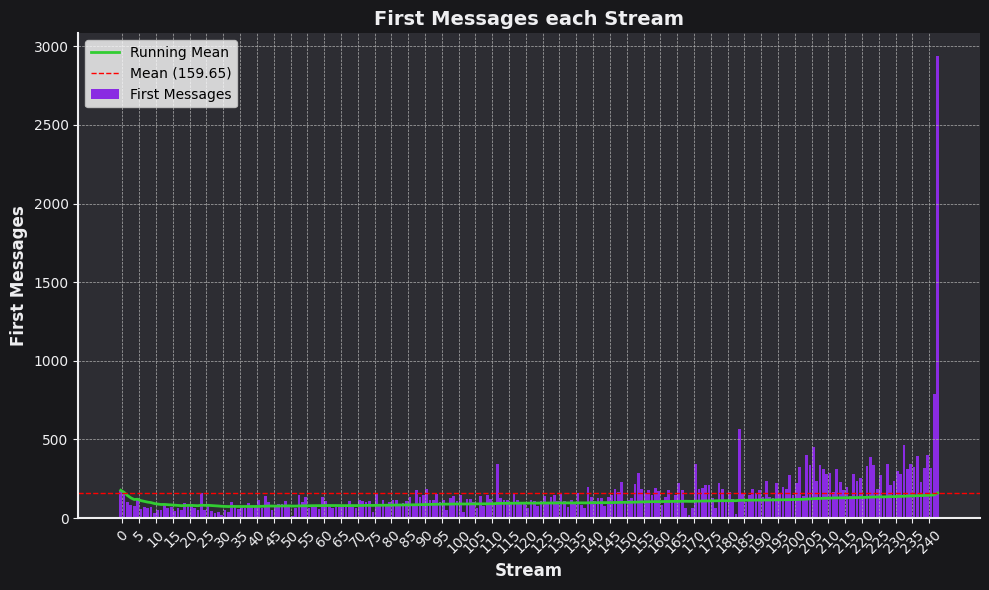

In [11]:
# Plot the chart
fig, ax = plt.subplots(figsize=(10, 6))

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels


# Bar plots
bar1 = ax.bar(index, stream_stats['first_messages'], color='#8A2BE2', edgecolor='none', alpha=1, label='First Messages')

# Plot the running mean line
ax.plot(index, stream_stats['first_messages_avg'], color='#32CD32', linestyle='-', linewidth=2, label='Running Mean')

# Draw the mean line
ax.axhline(mean_first_messages, color='r', linestyle='--', linewidth=1, label=f'Mean ({mean_first_messages:.2f})')

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title
ax.set_xlabel('Stream', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('First Messages', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('First Messages each Stream', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Adjusting x-axis ticks and labels to show every 5th label
xticks = np.arange(0, len(index), 5)
ax.set_xticks([i +1 / 2 for i in xticks])
ax.set_xticklabels(stream_stats.index[xticks], fontsize=10, rotation=45, color=label_color)

# Adding grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Add legend
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()


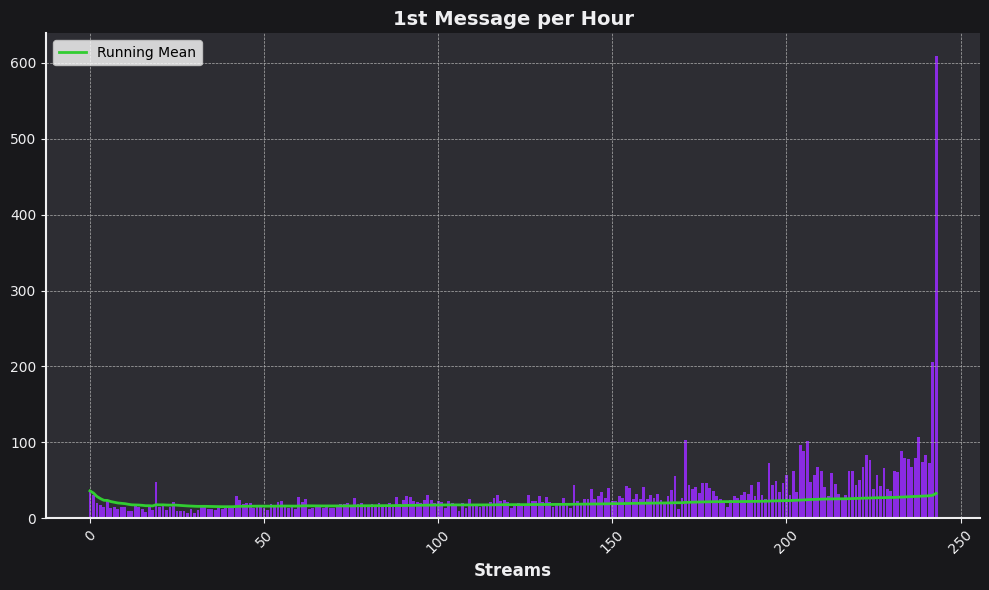

In [12]:
# Plot the chart with custom style
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for 'stream_length_per_first' with custom color and transparency
ax.bar(stream_stats.index, 
       stream_stats['stream_length_per_firt'], 
       edgecolor='none',
       color='#8A2BE2',  # Custom color for bars
       alpha=1           # Transparency  
      )
# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Calculate mean of first messages
mean_stream_length_per_firt = stream_stats['stream_length_per_firt'].expanding().mean()


# Plot the running mean line
ax.plot(stream_stats.index,  # Ensure this is correctly defined
        mean_stream_length_per_firt, 
        color='#32CD32', 
        linestyle='-', 
        linewidth=2, 
        label='Running Mean'
       )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('1st Message per Hour', fontsize=14, fontweight='bold', color=label_color)


# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()


In [13]:
stream_stats['message_count'].head(5)

stream
0    1985
1    3046
2    2754
3    2375
4    2455
Name: message_count, dtype: int64

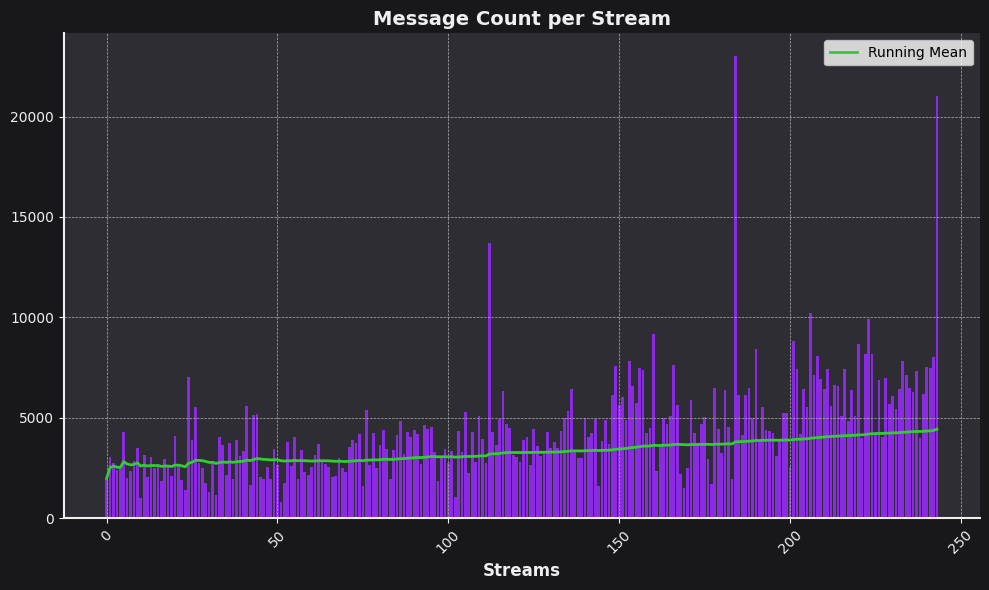

In [14]:
# Plot the chart with custom style
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for 'message_count' with custom color and transparency
ax.bar(stream_stats.index, 
       stream_stats['message_count'], 
       edgecolor='none',
       color='#8A2BE2',  # Custom color for bars
       alpha=1           # Transparency  
      )

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Calculate running mean for 'message_count'
mean_message_count = stream_stats['message_count'].expanding().mean()

# Plot the running mean line
ax.plot(stream_stats.index,  
        mean_message_count, 
        color='#32CD32', 
        linestyle='-', 
        linewidth=2, 
        label='Running Mean'
       )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Message Count per Stream', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()

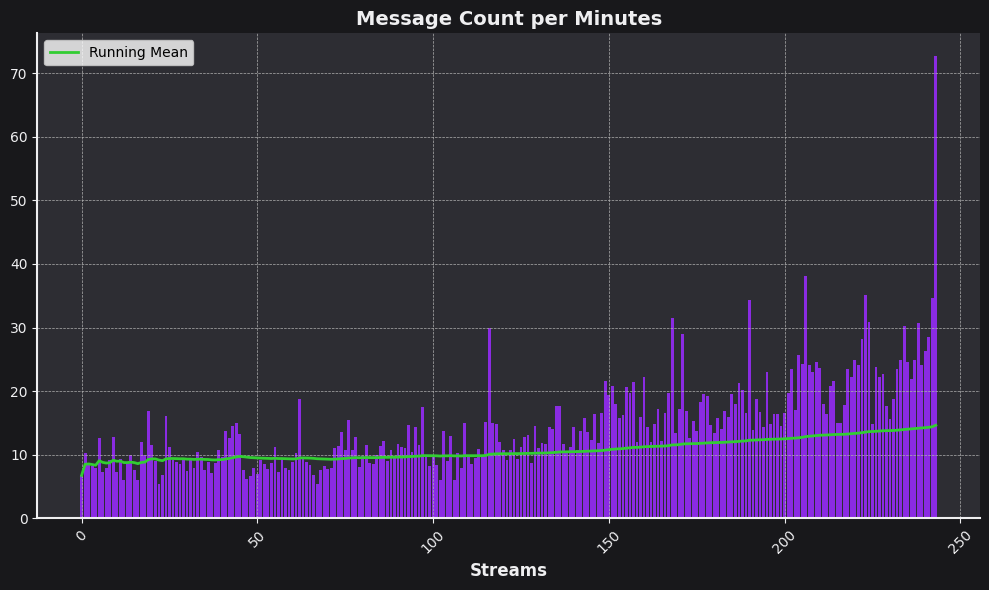

In [15]:
# Plot the chart with custom style
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for 'message_per_min' with custom color and transparency
ax.bar(stream_stats.index, 
       stream_stats['message_per_min'], 
       edgecolor='none',
       color='#8A2BE2',  # Custom color for bars
       alpha=1           # Transparency  
      )

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Calculate running mean for 'message_count'
mean_message_per_min = stream_stats['message_per_min'].expanding().mean()

# Plot the running mean line
ax.plot(stream_stats.index,  
        mean_message_per_min, 
        color='#32CD32', 
        linestyle='-', 
        linewidth=2, 
        label='Running Mean'
       )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Message Count per Minutes', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()

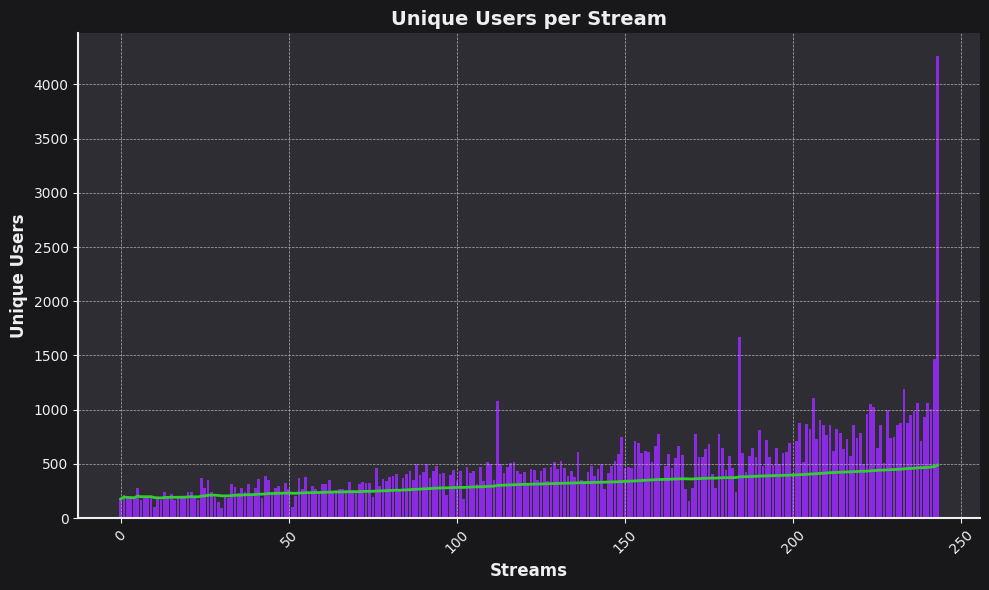

In [16]:
# Plot the chart with custom style
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for 'unique_chatters' with custom color and transparency
ax.bar(stream_stats.index, 
       stream_stats['unique_chatters'],
       edgecolor='none', 
       color='#8A2BE2',  # Custom color for bars
       alpha=1           # Transparency  
      )

# Calculate mean of unique chatters
mean_stream_unique = stream_stats['unique_chatters'].expanding().mean()

# Draw the mean line with custom style
ax.plot(mean_stream_unique, 
           color='#32CD32',          # Custom color for mean line
           linestyle='-',           # Line style
           linewidth=2,              # Line width
          )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Unique Users', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Unique Users per Stream', fontsize=14, fontweight='bold', color=label_color)

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

plt.tight_layout()
plt.show()


In [17]:
# Calculate mean of first messages
stream_stats['unique_chatters_per_hour_avg'] = stream_stats['unique_chatters_per_hour'].expanding().mean()

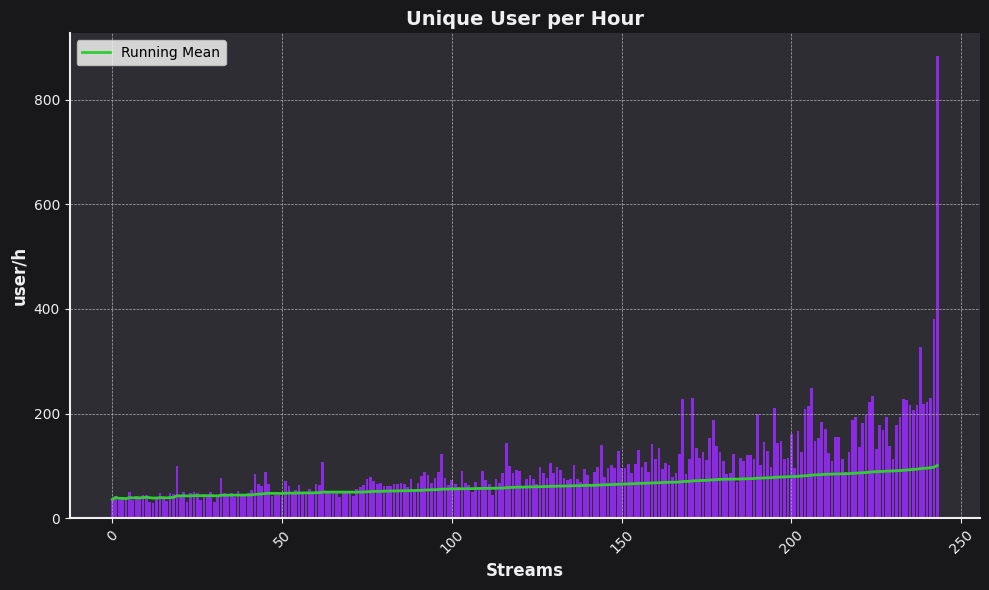

In [18]:

fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels

# Bar plot for 'unique_chatters_per_hour'
ax.bar(stream_stats.index, 
       stream_stats['unique_chatters_per_hour'],
       edgecolor='none', 
       color='#8A2BE2',  # Custom color for bars
       alpha=1      # Transparency  
      )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Plot the running mean line
ax.plot(stream_stats.index,  # Ensure this is correctly defined
        stream_stats['unique_chatters_per_hour_avg'], 
        color='#32CD32', 
        linestyle='-', 
        linewidth=2, 
        label='Running Mean'
       )

# Labels and title
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('user/h', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Unique User per Hour', fontsize=14, fontweight='bold', color=label_color)

# Adding grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()


In [19]:
# Group by stream and aggregate users
stream_users = data.groupby('stream')['user'].apply(set).reset_index()
stream_users.columns = ['stream', 'users']

# Initialize columns for returning users and their count
stream_users['returning_users'] = [set()] * len(stream_users)
stream_users['returning_count'] = 0

# Loop through streams to identify returning users
for i in range(1, len(stream_users)):
    current_users = stream_users.at[i, 'users']
    previous_users = stream_users.at[i - 1, 'users']
    
    # Identify returning users
    returning_users = current_users.intersection(previous_users)
    
    # Update dataframe with returning users and their count
    stream_users.at[i, 'returning_users'] = returning_users
    stream_users.at[i, 'returning_count'] = len(returning_users)

In [20]:
stream_stats = pd.merge(stream_stats, stream_users, on='stream', how='right')

In [21]:
# Calculate mean of first messages
stream_stats['returning_count_avg'] = stream_stats['returning_count'].expanding().mean()

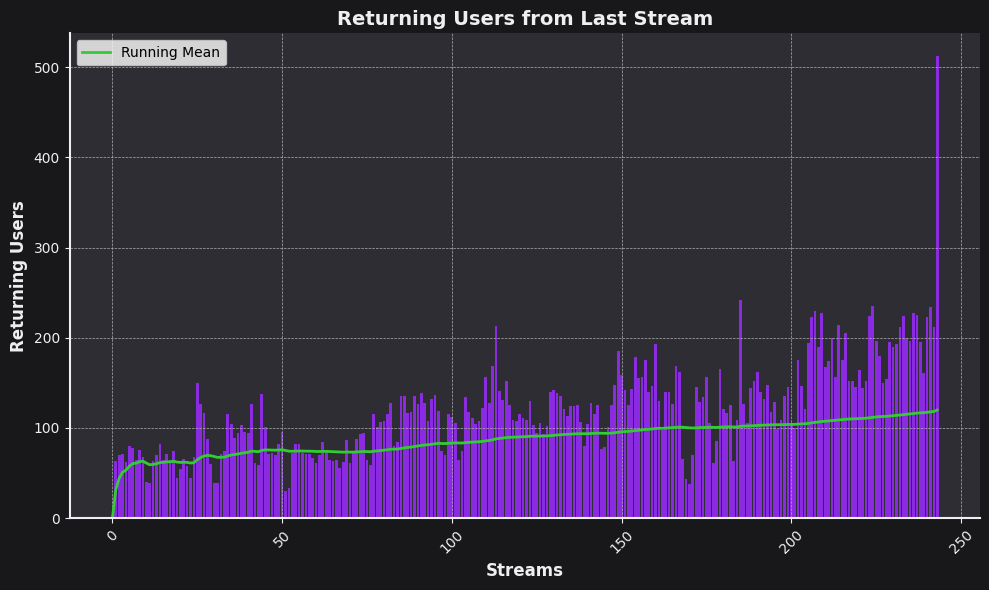

In [22]:
# Plot the chart with custom style
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for 'returning_count' with custom color and transparency
ax.bar(stream_stats.index, 
       stream_stats['returning_count'],
       edgecolor='none', 
       color='#8A2BE2',  # Custom color for bars
       alpha=1           # Transparency  
      )

# Plot the running mean line with custom style
ax.plot(stream_stats.index, 
        stream_stats['returning_count_avg'], 
        color='#32CD32',          # Custom color for running mean line
        linestyle='-',           # Line style
        linewidth=2,              # Line width
        label='Running Mean'
       )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Returning Users', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Returning Users from Last Stream', fontsize=14, fontweight='bold', color=label_color)

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()


In [23]:
# Create a new column for the first-time chatters by subtracting returning_count from unique_chatters
stream_stats['grouped_return_first'] = stream_stats['returning_count'] + stream_stats['first_messages']

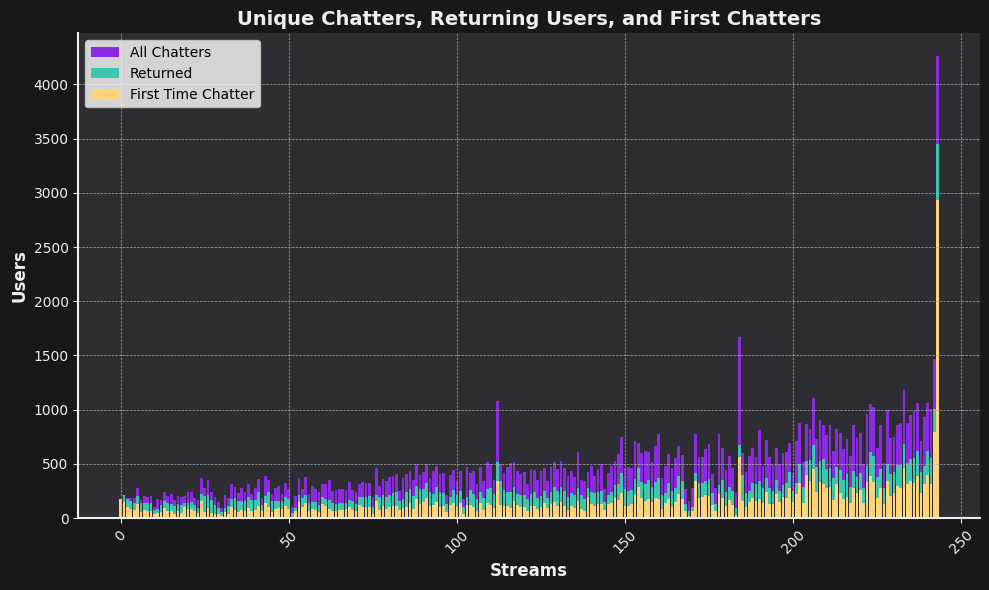

In [24]:
# Plot the bars with specified colors
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for all chatters (base layer)
ax.bar(stream_stats.index, 
       stream_stats['unique_chatters'], 
       label='All Chatters',
       edgecolor='none', 
       color='#8A2BE2',  # Custom color for the first set of bars (purple)
       alpha=1           # Transparency
      )

# Bar plot for returning users (stacked on top)
ax.bar(stream_stats.index, 
       stream_stats['grouped_return_first'], 
       label='Returned',
       edgecolor='none', 
       color='#3DC6AE',  # Custom color for the second set of bars
       alpha=1           # Transparency
      )

# Bar plot for first-time chatters (stacked on top)
ax.bar(stream_stats.index, 
       stream_stats['first_messages'], 
       label='First Time Chatter',
       edgecolor='none', 
       color='#FFD37A',  # Custom color for the third set of bars
       alpha=1           # Transparency
      )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Users', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Unique Chatters, Returning Users, and First Chatters', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Adding legend to differentiate the bars
ax.legend()

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()


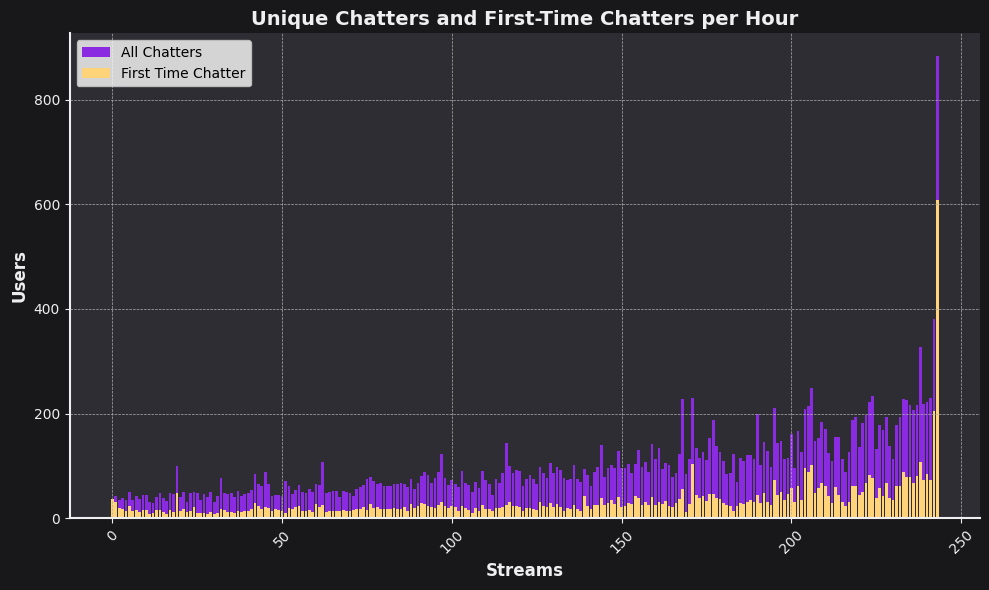

In [25]:
# Plot the bars with specified colors
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for all chatters
ax.bar(stream_stats.index, 
       stream_stats['unique_chatters_per_hour'], 
       label='All Chatters',
       edgecolor='none', 
       color='#8A2BE2',  # Custom color for the first set of bars (purple)
       alpha=1           # Transparency
      )

# Bar plot for first-time chatters (stacked on top)
ax.bar(stream_stats.index, 
       stream_stats['stream_length_per_firt'], 
       label='First Time Chatter',
       edgecolor='none', 
       color='#FFD37A',  # Custom color for the second set of bars (yellow)
       alpha=1           # Transparency
      )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Users', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Unique Chatters and First-Time Chatters per Hour', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Adding legend to differentiate the bars
ax.legend()

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()


In [26]:
# Path to your Excel file
file_path = 'DorozeaStreamStats.xlsx'

# Reading a specific sheet with custom column names and skipping the first two rows
exelStats = pd.read_excel(file_path, sheet_name='Munkalap1', header=None, names=['stream', 'avg', 'max','follow','games'], skiprows=1)


In [27]:
stream_stats = pd.merge(stream_stats, exelStats, on='stream', how='right')


In [28]:
#user with only 1 messege

# 1. Group by stream and user, and count the number of messages per user in each stream
user_message_counts = data.groupby(['stream', 'user']).size().reset_index(name='message_count')

# 2. Filter to keep only users who sent exactly one message in a stream
one_message_users = user_message_counts[user_message_counts['message_count'] == 1]

# 3. Count the number of such users for each stream
one_message_user_counts = one_message_users.groupby('stream').size().reset_index(name='one_message_user_count')

# 4. Merge this new information into the stream_stats dataframe
stream_stats = stream_stats.merge(one_message_user_counts, on='stream', how='left')

In [29]:
#2 or more messeges
stream_stats['two_or_more_message_user_counts'] = stream_stats['unique_chatters'] - stream_stats['one_message_user_count']

In [30]:
#message per chater
stream_stats['message_per_chater'] = stream_stats['total_messages'] / stream_stats['unique_chatters']

In [31]:
#hours watched
stream_stats['hours_watched'] = stream_stats['stream_length_hour'] * stream_stats['avg']

In [32]:
#total words count

# 1. Calculate the word count for each message
data['word_count'] = data['message'].apply(lambda x: len(x.split()))

# 2. Sum the word counts for each stream
stream_word_counts = data.groupby('stream')['word_count'].sum().reset_index(name='total_word_count')

# 3. Merge this new information into the stream_stats dataframe
stream_stats = stream_stats.merge(stream_word_counts, on='stream', how='left')

# If there are streams without any messages, fill NaN with 0
stream_stats['total_word_count'] = stream_stats['total_word_count'].fillna(0).astype(int)

In [33]:
#messege/min
stream_stats['message_per_min'] = stream_stats['total_messages'] / stream_stats['stream_length_hour'] / 60


In [34]:
#No stream elements
dataNoBots = data[data['user'] != 'StreamElements']
dataNoBots = dataNoBots[dataNoBots['user'] != 'Fossabot']

In [35]:
# 1. Count the number of messages per user in each stream
user_message_counts = dataNoBots.groupby(['stream', 'user']).size().reset_index(name='message_count')

# 2. Find the top 5 users for each stream
top_5_users = user_message_counts.groupby('stream').apply(
    lambda x: x.nlargest(5, 'message_count')['user'].tolist()
).reset_index(name='top_5_users')

# Convert the list to a comma-separated string for easier viewing
top_5_users['top_5_users'] = top_5_users['top_5_users'].apply(lambda x: ', '.join(x))

# 3. Merge this information into the stream_stats dataframe
stream_stats = stream_stats.merge(top_5_users[['stream', 'top_5_users']], on='stream', how='left')


C:\Users\Kardo\AppData\Local\Temp\ipykernel_16596\2347536326.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_users = user_message_counts.groupby('stream').apply(


In [36]:
stream_stats['top_5_users'].tail(10)

234    banties_x, elluiti, cukululu41, ifanbenmezda, ...
235    cukululu41, JBIN2036, balintboss, stan_iv4, Ma...
236    elluiti, nienawisc22, JBIN2036, balintboss, cu...
237    CrazeE420xd, JBIN2036, cukululu41, stan_iv4, C...
238    elluiti, cukululu41, CrazeE420xd, theprimephil...
239    cukululu41, banties_x, stan_iv4, balintboss, J...
240    CrazeE420xd, ttrek_, JBIN2036, stan_iv4, cukul...
241    elluiti, banties_x, cukululu41, stan_iv4, ifan...
242    elluiti, JBIN2036, ifanbenmezda, stan_iv4, cuk...
243    banties_x, elluiti, JBIN2036, Hueqi, ifanbenmezda
Name: top_5_users, dtype: object

In [37]:
#top 5 word in chat


# Define the list of words to exclude
stop_words = {  'the','a','is','to','and','i','you','in','it','u','for',']','so','on',
                'my','are','of','this','they','/','like','have','that','its','?','!','but',
                #maybe not
                'just','was','what','your','can','not','if','she','him','we','they','at','from',
                'by','be','he','do','with','dont','did'
            }

# 1. Tokenize messages by splitting them into words
#data['words'] = data['message'].apply(lambda x: x.split())

# Tokenize messages, splitting into words and filtering out stop words
dataNoBots = dataNoBots.copy()
dataNoBots['words'] = dataNoBots['message'].apply(lambda x: [word for word in x.split() if word.lower() not in stop_words])


# 2. Aggregate all words per stream
stream_words = dataNoBots.groupby('stream')['words'].sum().reset_index()

# 3. Calculate the top 5 most common words for each stream
stream_words['top_5_words'] = stream_words['words'].apply(lambda x: [word for word, count in Counter(x).most_common(5)])

# Convert list to a comma-separated string for easier viewing
stream_words['top_5_words'] = stream_words['top_5_words'].apply(lambda x: ', '.join(x))

# 4. Merge this information into the stream_stats dataframe
stream_stats = stream_stats.merge(stream_words[['stream', 'top_5_words']], on='stream', how='left')

In [38]:
stream_stats['top_5_words'].tail(10)

234                        !boost, !play, 󠀀, ome44, o7
235                     mikuPls, play, LOL, OOOO, game
236                     ome44, LOL, @dorozea, OOOO, no
237                xar2EDM, !play, xJAM, catPls, ome44
238                             ome44, doro, 1, qq, hi
239                       !watchtime, LOL, doro, 1, no
240    WideRaveTime, WideCatGroove, ome44, widetime, 1
241              FeelsStrongMan, OOOO, HERE, o7, ome44
242                        <3, LOVE, RUSSIA, WW, ome44
243                      <3, ome44, FEIN, LOVE, RUSSIA
Name: top_5_words, dtype: object

In [39]:
#stream_stats['top_5_words'].to_csv('top_5_words.txt', index=False, header=False)

In [40]:
subData = data[data.apply(lambda row: row['user'].lower() in row['message'].lower(), axis=1)]
subData =  subData[~subData['message'].str.contains(' converted from ', case=False, na=False)]
giftedData = subData[subData['message'].str.contains(' sub ', case=False, na=False)]

unique_gifter = giftedData['user'].nunique()
print("Number of unique Gifter:", unique_gifter)

Number of unique Gifter: 353


In [41]:
giftedData.head(10)

,date,user,message,stream,first_message,word_count
121,2024-05-01 17:14:43+02:00,yusuf2774,yusuf2774 gifted a Tier 1 sub to ChickenBurgah...,0,0,8
567,2024-05-01 18:29:11+02:00,x3lolx,x3lolx gifted a Tier 1 sub to ArtMassong!,0,0,8
569,2024-05-01 18:30:00+02:00,x3lolx,x3lolx gifted a Tier 1 sub to PrachtkerleDE!,0,0,8
576,2024-05-01 18:31:10+02:00,x3lolx,x3lolx gifted a Tier 1 sub to lubb1x!,0,0,8
661,2024-05-01 18:41:16+02:00,x3lolx,x3lolx gifted a Tier 1 sub to alaskalyeska!,0,0,8
1076,2024-05-01 19:54:29+02:00,Bizzan,Bizzan gifted a Tier 1 sub to shotashellz!,0,0,8
1077,2024-05-01 19:54:29+02:00,Bizzan,Bizzan gifted a Tier 1 sub to aabeemick!,0,0,8
1078,2024-05-01 19:54:29+02:00,Bizzan,Bizzan gifted a Tier 1 sub to gantl4!,0,0,8
1079,2024-05-01 19:54:29+02:00,Bizzan,Bizzan gifted a Tier 1 sub to Minaqua__!,0,0,8
1080,2024-05-01 19:54:29+02:00,Bizzan,Bizzan gifted a Tier 1 sub to FeiFuchs!,0,0,8


In [42]:
gifterData = subData[subData['message'].str.contains(' is gifting ', case=False, na=False)].copy()
gifterData['gifts'] = gifterData['message'].apply(lambda x: int(re.search(r'gifting\s(\d+)', x).group(1)))

gift_per_stream_2 = gifterData.groupby('stream')['gifts'].sum()

stream_stats = pd.merge(stream_stats, gift_per_stream_2, on='stream', how='left')

stream_stats = stream_stats.rename(columns={'gifts': 'gift2'})
stream_stats['gift2'] = stream_stats['gift2'].fillna(0)

In [43]:
stream_stats['gift2'].head(5)

0    25.0
1    31.0
2     0.0
3     5.0
4     0.0
Name: gift2, dtype: float64

In [44]:
unique_users_per_stream = giftedData.groupby('stream')['user'].nunique()

stream_stats = pd.merge(stream_stats, unique_users_per_stream, on='stream', how='left')

stream_stats = stream_stats.rename(columns={'user': 'gifter'})
stream_stats['gifter'] = stream_stats['gifter'].fillna(0)

In [45]:
stream_stats['gifter'].describe()

count    244.000000
mean       3.032787
std        3.031887
min        0.000000
25%        1.000000
50%        2.000000
75%        4.250000
max       21.000000
Name: gifter, dtype: float64

In [46]:
gift_per_stream = giftedData.groupby('stream')['user'].count()

stream_stats = pd.merge(stream_stats, gift_per_stream, on='stream', how='left')

stream_stats = stream_stats.rename(columns={'user': 'gift'})
stream_stats['gift'] = stream_stats['gift'].fillna(0)

In [47]:
stream_stats['gift'] = np.maximum(stream_stats['gift'], stream_stats['gift2'])

In [48]:
raids = subData[subData['message'].str.contains(' raiders from ', case=False, na=False)].copy()
raids['raid'] = raids['message'].str.split().str[0]
raids['raid'] = pd.to_numeric(raids['raid'], errors='raise')

raid_stream = raids.groupby('stream')['raid'].max()
stream_stats = pd.merge(stream_stats, raid_stream, on='stream', how='left')
stream_stats['raid'] = stream_stats['raid'].fillna(0)


stream_stats['raid'].head(5)

0      4.0
1    125.0
2      0.0
3      0.0
4      0.0
Name: raid, dtype: float64

In [49]:
stream_stats['raid'].tail(5)

239        0.0
240        0.0
241        0.0
242      123.0
243    50101.0
Name: raid, dtype: float64

In [50]:
raids.sort_values(by='stream').tail(5)

,date,user,message,stream,first_message,word_count,raid
1016220,2025-02-09 15:44:00+01:00,wabiiisabii,283 raiders from wabiiisabii have joined!,236,0,6,283
1014008,2025-02-09 14:24:27+01:00,xoxoGledi,22 raiders from xoxoGledi have joined!,236,0,6,22
1029457,2025-02-11 19:40:30+01:00,SenshiSuni,9 raiders from SenshiSuni have joined!,238,0,6,9
1055330,2025-02-16 18:22:36+01:00,gkey,123 raiders from gkey have joined!,242,0,6,123
1078591,2025-02-17 20:26:47+01:00,buster,50101 raiders from buster have joined!,243,0,6,50101


In [51]:
primeData = subData[subData['message'].str.contains('Prime', case=False, na=False)]

prime_per_stream = primeData.groupby('stream')['user'].count()

stream_stats = pd.merge(stream_stats, prime_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'prime'})
stream_stats['prime'] = stream_stats['prime'].fillna(0)

#stream_stats['prime'].describe()
stream_stats.head(5)


,stream,first_messages,total_messages,unique_chatters,message_count,stream_length,stream_length_hour,stream_length_per_firt,unique_chatters_per_hour,message_per_min,...,message_per_chater,hours_watched,total_word_count,top_5_users,top_5_words,gift2,gifter,gift,raid,prime
0,0,177,1985,177,1985,17697.0,4.915833,36.006103,36.006103,6.729954,...,11.214689,634.142500,10568,"Martin_Gales, Banties1g, Jello_CS, 1206paul_, ...","1, doro, !play, good, omE",25.0,4.0,25.0,4.0,2.0
1,1,150,3046,213,3046,17831.0,4.953056,30.284336,43.003758,10.249565,...,14.300469,752.864444,14301,"Martin_Gales, saykokerem, klimzaa, LX212, Bant...","sigma, doro, !play, mhm, 1",31.0,4.0,31.0,125.0,1.0
2,2,104,2754,185,2754,19147.0,5.318611,19.553977,34.783517,8.630073,...,14.886486,670.145000,13389,"Banties1g, Martin_Gales, klimzaa, LX212, Wii_Gii","mhm, !play, omE, doro, good",0.0,0.0,0.0,0.0,2.0
3,3,84,2375,184,2375,17451.0,4.847500,17.328520,37.957710,8.165721,...,12.907609,644.717500,10244,"Martin_Gales, Banties1g, LX212, roxa0, zaxkyyy_","!play, mhm, doro, omE, LUL",5.0,2.0,6.0,0.0,1.0
4,4,76,2455,182,2455,18734.0,5.203889,14.604462,34.973844,7.862710,...,13.489011,770.175556,11883,"Martin_Gales, klimzaa, x3lolx, ylb_cat_soul22,...","mhm, doro, good, O?, me",0.0,0.0,0.0,0.0,2.0


In [52]:
trueSub =  subData[~ subData['message'].str.contains('Prime', case=False, na=False)]

trueSub = trueSub[~trueSub['message'].str.contains('raiders', case=False, na=False)]

trueSub = trueSub[~trueSub['message'].str.contains('gifting', case=False, na=False)]

trueSub = trueSub[~trueSub['message'].str.contains('gifted', case=False, na=False)]

trueSub = trueSub[trueSub['message'].str.contains(' subscribed at ', case=False, na=False)]



tier1 = trueSub[trueSub['message'].str.contains('Tier 1', case=False, na=False)]
tier2 = trueSub[trueSub['message'].str.contains('Tier 2', case=False, na=False)]
tier3 = trueSub[trueSub['message'].str.contains('Tier 3', case=False, na=False)]

tier1_per_stream = tier1.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, tier1_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'tier1'})
stream_stats['tier1'] = stream_stats['tier1'].fillna(0)

tier2_per_stream = tier2.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, tier2_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'tier2'})
stream_stats['tier2'] = stream_stats['tier2'].fillna(0)

tier3_per_stream = tier3.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, tier3_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'tier3'})
stream_stats['tier3'] = stream_stats['tier3'].fillna(0)


In [53]:
no_raid = stream_stats[stream_stats['raid']==0][['stream','avg', 'max']].copy()

In [54]:
no_raid.head(5)

,stream,avg,max
2,2,126,161
3,3,133,169
4,4,148,177
5,5,187,252
6,6,127,157


In [55]:

no_raid['per'] = (no_raid['max'] / no_raid['avg']) *100

correct_per = no_raid['per'].mean

In [56]:
stream_stats['avg_rolling'] = stream_stats['avg'].rolling(window=10).mean()

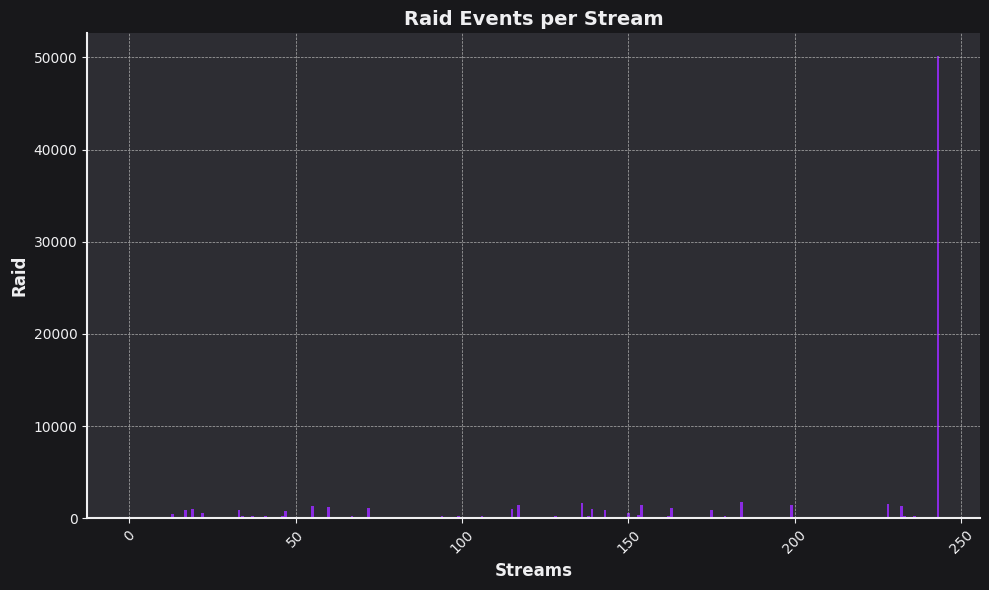

In [57]:
# Plot the bar chart with custom styling
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for raid
ax.bar(stream_stats.index, 
       stream_stats['raid'],
       edgecolor='none', 
       color='#8A2BE2',  # Custom color for bars (purple)
       alpha=1           # Transparency
      )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Raid', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Raid Events per Stream', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10, color=label_color)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()


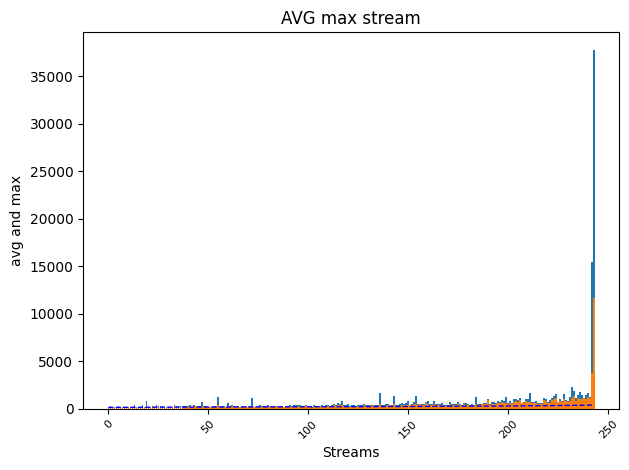

In [58]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for max viever
ax.bar(stream_stats.index, stream_stats['max'],edgecolor='none')

# Bar plot for abg viever
ax.bar(stream_stats.index, stream_stats['avg'],edgecolor='none')

stream_stats['epanding_avg'] = stream_stats['avg'].expanding().mean()
# Plot the running mean line
ax.plot(index, stream_stats['epanding_avg'], color='b', linestyle='--', linewidth=1, label='Running Mean')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('avg and max', fontsize=10)
ax.set_title('AVG max stream', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

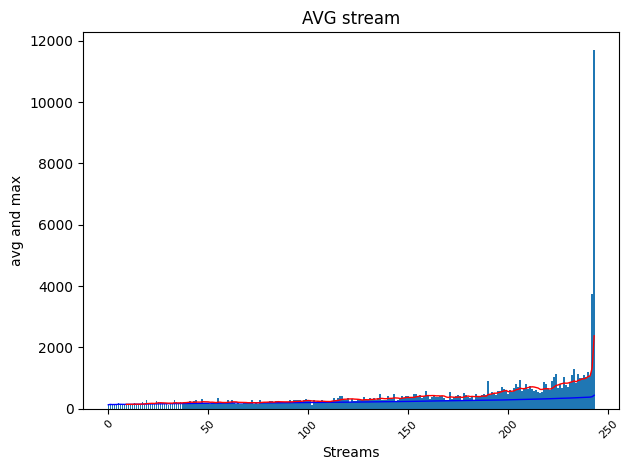

In [59]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for abg viever
ax.bar(stream_stats.index, stream_stats['avg'],edgecolor='none')

# Plot the running mean line
ax.plot(index, stream_stats['epanding_avg'], color='b', linestyle='-', linewidth=1, label='Running Mean')

# Plot the running mean line
ax.plot(index, stream_stats['avg_rolling'], color='r', linestyle='-', linewidth=1, label='Running Mean')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('avg and max', fontsize=10)
ax.set_title('AVG stream', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

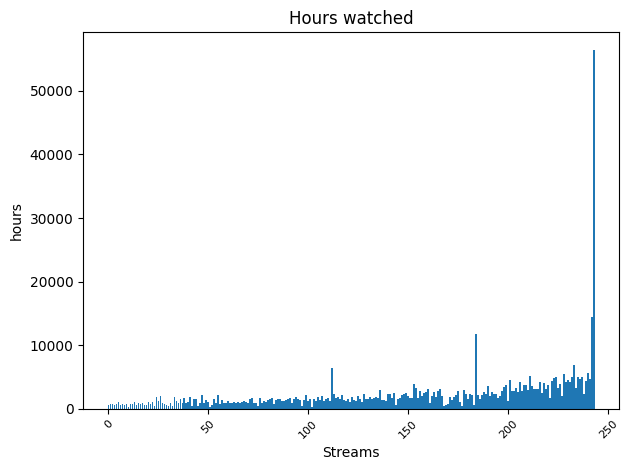

In [60]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for abg viever
ax.bar(stream_stats.index, stream_stats['hours_watched'],edgecolor='none')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('hours', fontsize=10)
ax.set_title('Hours watched', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

In [61]:
stream_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 38 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   stream                           244 non-null    int64  
 1   first_messages                   244 non-null    int64  
 2   total_messages                   244 non-null    int64  
 3   unique_chatters                  244 non-null    int64  
 4   message_count                    244 non-null    int64  
 5   stream_length                    244 non-null    float64
 6   stream_length_hour               244 non-null    float64
 7   stream_length_per_firt           244 non-null    float64
 8   unique_chatters_per_hour         244 non-null    float64
 9   message_per_min                  244 non-null    float64
 10  first_messages_avg               244 non-null    float64
 11  unique_chatters_per_hour_avg     244 non-null    float64
 12  users                 

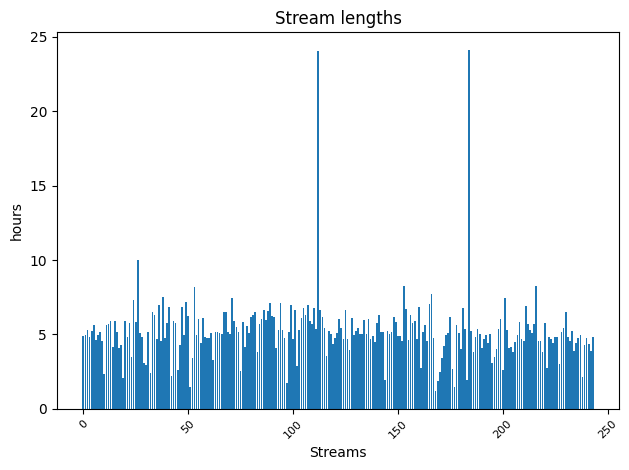

In [62]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for abg viever
ax.bar(stream_stats.index, stream_stats['stream_length_hour'],edgecolor='none')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('hours', fontsize=10)
ax.set_title('Stream lengths', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

In [63]:

stream_stats.head(2)

,stream,first_messages,total_messages,unique_chatters,message_count,stream_length,stream_length_hour,stream_length_per_firt,unique_chatters_per_hour,message_per_min,...,gift2,gifter,gift,raid,prime,tier1,tier2,tier3,avg_rolling,epanding_avg
0,0,177,1985,177,1985,17697.0,4.915833,36.006103,36.006103,6.729954,...,25.0,4.0,25.0,4.0,2.0,3.0,0.0,0.0,NaN,129.0
1,1,150,3046,213,3046,17831.0,4.953056,30.284336,43.003758,10.249565,...,31.0,4.0,31.0,125.0,1.0,1.0,0.0,0.0,NaN,140.5


In [64]:
stream_stats.tail(2)

,stream,first_messages,total_messages,unique_chatters,message_count,stream_length,stream_length_hour,stream_length_per_firt,unique_chatters_per_hour,message_per_min,...,gift2,gifter,gift,raid,prime,tier1,tier2,tier3,avg_rolling,epanding_avg
242,242,792,8029,1469,8029,13894.0,3.859444,205.210882,380.624730,34.672521,...,476.0,10.0,476.0,123.0,18.0,14.0,0.0,0.0,1337.5,392.300412
243,243,2936,21031,4257,21031,17367.0,4.824167,608.602522,882.432199,72.658490,...,807.0,21.0,807.0,50101.0,22.0,89.0,0.0,0.0,2376.5,438.606557


In [65]:
#stream_stats.to_csv('combined_output.csv', index=False)

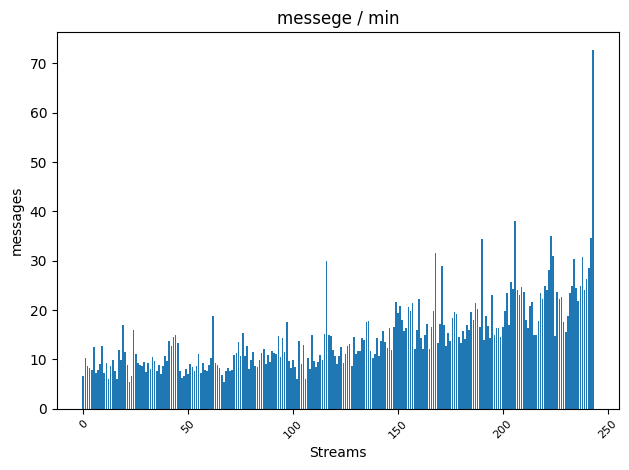

In [66]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for max viever
ax.bar(stream_stats.index, stream_stats['message_per_min'],edgecolor='none')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('messages', fontsize=10)
ax.set_title('messege / min', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

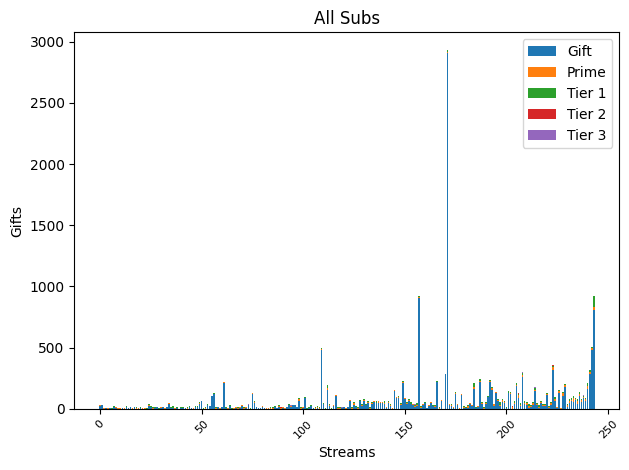

In [67]:
import matplotlib.pyplot as plt

# Plot the chart
fig, ax = plt.subplots()

# Stacked bar plot
ax.bar(stream_stats.index, stream_stats['gift'],edgecolor='none', label='Gift')
ax.bar(stream_stats.index, stream_stats['prime'], bottom=stream_stats['gift'],edgecolor='none', label='Prime')
ax.bar(stream_stats.index, stream_stats['tier1'], bottom=stream_stats['gift'] + stream_stats['prime'],edgecolor='none', label='Tier 1')
ax.bar(stream_stats.index, stream_stats['tier2'], bottom=stream_stats['gift'] + stream_stats['prime'] + stream_stats['tier1'],edgecolor='none', label='Tier 2')
ax.bar(stream_stats.index, stream_stats['tier3'], bottom=stream_stats['gift'] + stream_stats['prime'] + stream_stats['tier1'] + stream_stats['tier2'],edgecolor='none', label='Tier 3')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('Gifts', fontsize=10)
ax.set_title('All Subs', fontsize=12)

# Adding legend to differentiate the bars
ax.legend()

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()


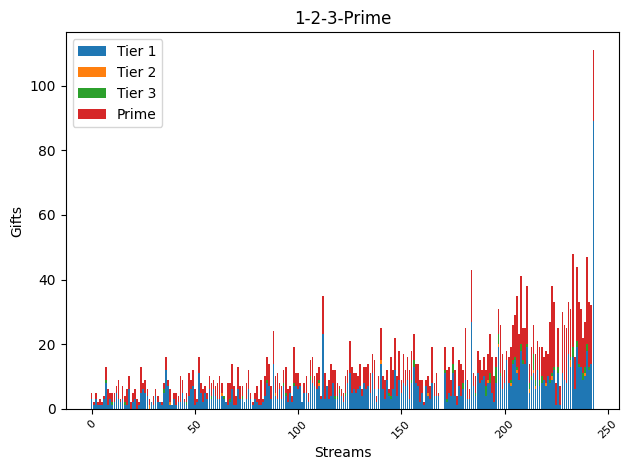

In [68]:
# Plot the chart
fig, ax = plt.subplots()

# Stacked bar plot
ax.bar(stream_stats.index, stream_stats['tier1'],edgecolor='none', label='Tier 1')
ax.bar(stream_stats.index, stream_stats['tier2'], bottom=stream_stats['tier1'],edgecolor='none', label='Tier 2')
ax.bar(stream_stats.index, stream_stats['tier3'], bottom=stream_stats['tier1'] + stream_stats['tier2'],edgecolor='none', label='Tier 3')
ax.bar(stream_stats.index, stream_stats['prime'], bottom=stream_stats['tier1'] + stream_stats['tier2'] + stream_stats['tier3'],edgecolor='none', label='Prime')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('Gifts', fontsize=10)
ax.set_title('1-2-3-Prime', fontsize=12)

# Adding legend to differentiate the bars
ax.legend()

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()


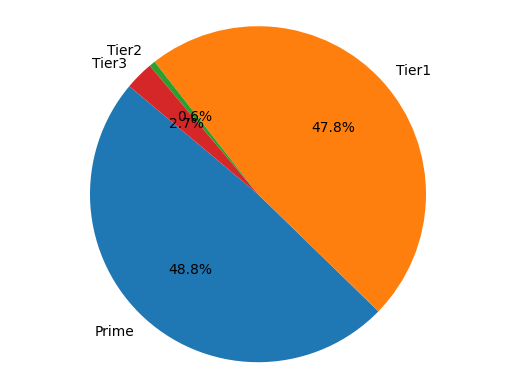

In [69]:
# Data to plot
labels = ['Prime', 'Tier1', 'Tier2', 'Tier3']
sizes = [primeData.shape[0], tier1.shape[0], tier2.shape[0], tier3.shape[0]]

sizes

# Plotting the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  

# Show the pie chart
plt.show()


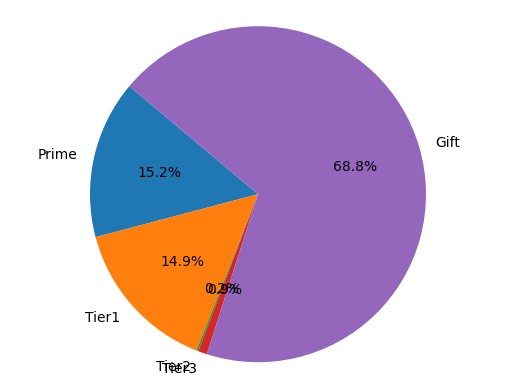

In [70]:
# Data to plot
labels = ['Prime', 'Tier1', 'Tier2', 'Tier3','Gift']
sizes = [primeData.shape[0], tier1.shape[0], tier2.shape[0], tier3.shape[0],giftedData.shape[0]]

sizes

# Plotting the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  

# Show the pie chart
plt.show()


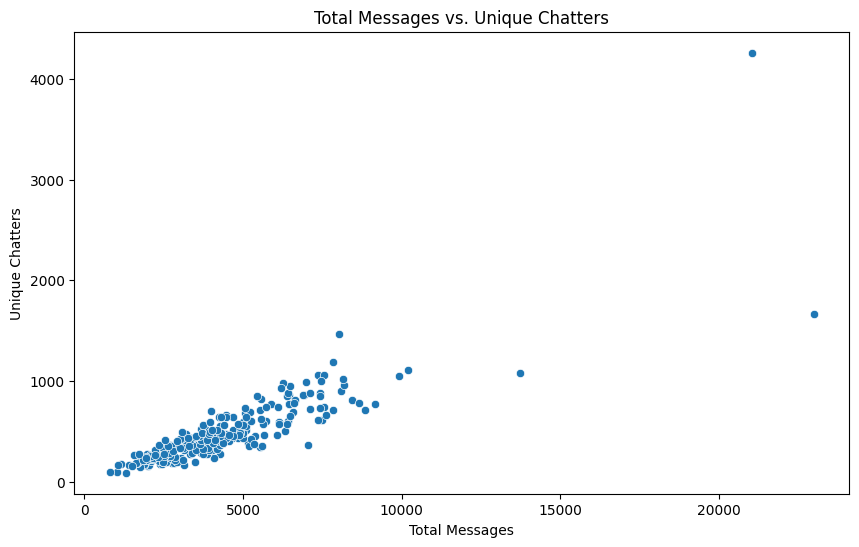

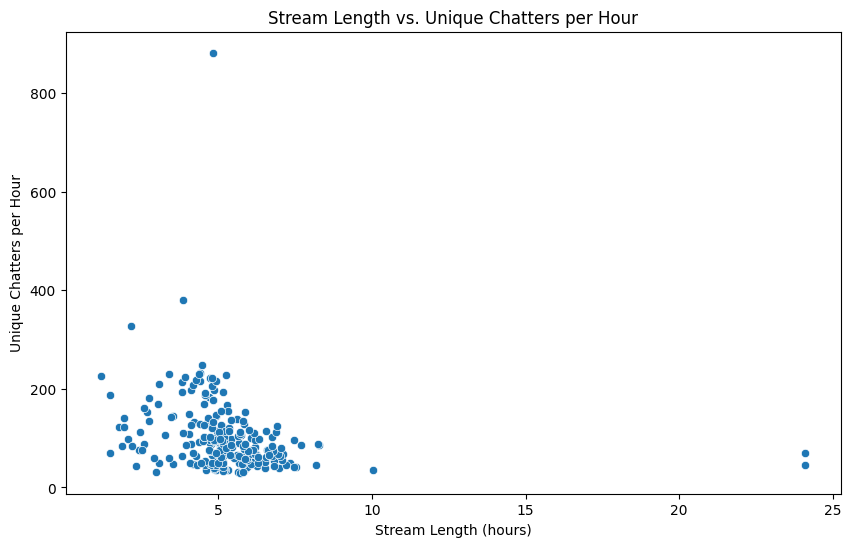

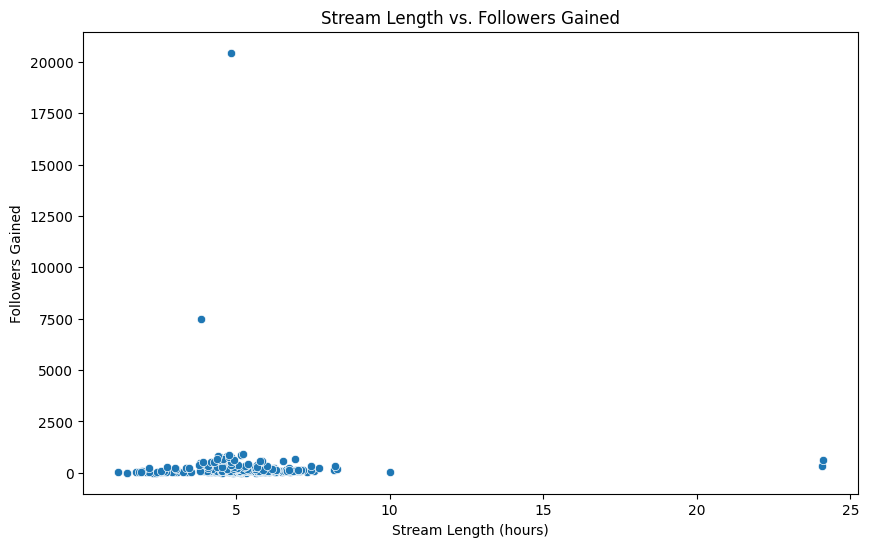

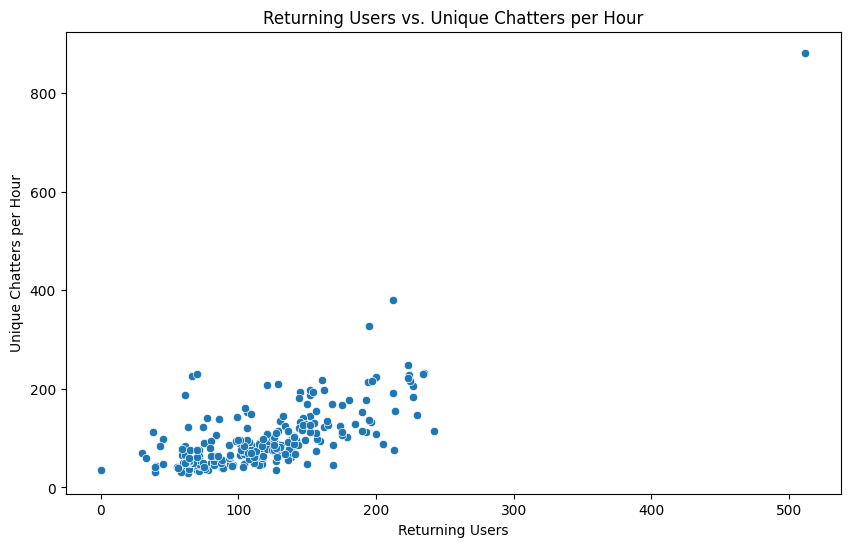

In [71]:

# Scatter plot for Total Messages vs. Unique Chatters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=stream_stats['total_messages'], y=stream_stats['unique_chatters'])
plt.title('Total Messages vs. Unique Chatters')
plt.xlabel('Total Messages')
plt.ylabel('Unique Chatters')
plt.show()

# Scatter plot for Stream Length vs. Unique Chatters per Hour
plt.figure(figsize=(10, 6))
sns.scatterplot(x=stream_stats['stream_length_hour'], y=stream_stats['unique_chatters_per_hour'])
plt.title('Stream Length vs. Unique Chatters per Hour')
plt.xlabel('Stream Length (hours)')
plt.ylabel('Unique Chatters per Hour')
plt.show()

# Scatter plot for Stream Length vs. Followers Gained
plt.figure(figsize=(10, 6))
sns.scatterplot(x=stream_stats['stream_length_hour'], y=stream_stats['follow'])
plt.title('Stream Length vs. Followers Gained')
plt.xlabel('Stream Length (hours)')
plt.ylabel('Followers Gained')
plt.show()

# Scatter plot for Returning Users vs. Unique Chatters per Hour
plt.figure(figsize=(10, 6))
sns.scatterplot(x=stream_stats['returning_count'], y=stream_stats['unique_chatters_per_hour'])
plt.title('Returning Users vs. Unique Chatters per Hour')
plt.xlabel('Returning Users')
plt.ylabel('Unique Chatters per Hour')
plt.show()

In [72]:
# Split the 'games' column into lists
stream_stats['games_list'] = stream_stats['games'].str.split(', ')

# Get the unique games across all streams
unique_games = set(sum(stream_stats['games_list'].tolist(), []))- {''}

# Create a column for each unique game
for game in unique_games:
    stream_stats[game] = stream_stats['games_list'].apply(lambda x: 1 if game in x else 0)

# Drop the temporary 'games_list' column
stream_stats.drop(columns=['games_list'], inplace=True)


In [73]:
stream_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 83 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   stream                           244 non-null    int64  
 1   first_messages                   244 non-null    int64  
 2   total_messages                   244 non-null    int64  
 3   unique_chatters                  244 non-null    int64  
 4   message_count                    244 non-null    int64  
 5   stream_length                    244 non-null    float64
 6   stream_length_hour               244 non-null    float64
 7   stream_length_per_firt           244 non-null    float64
 8   unique_chatters_per_hour         244 non-null    float64
 9   message_per_min                  244 non-null    float64
 10  first_messages_avg               244 non-null    float64
 11  unique_chatters_per_hour_avg     244 non-null    float64
 12  users                 

In [74]:
unique_games

{'awards',
 'batman',
 'batman2',
 'batman3',
 'carb',
 'chainedtogether',
 'codbo6',
 'crab',
 'cs',
 'deadatnigth',
 'deadlock',
 'demonologist',
 'detroid',
 'elden',
 'er',
 'fnf',
 'fornite',
 'fortnite',
 'irl',
 'jc',
 'lanoire',
 'letalcomp',
 'lol',
 'madison',
 'marbels',
 'marvel',
 'mc',
 'ow',
 'ow2',
 'parasocial',
 'phazmo',
 'pubg',
 'rdr1',
 'rdr2',
 're2',
 're3',
 're4',
 're5',
 'roblox',
 'rocket',
 'sh2',
 'special',
 'terraria',
 'tf2',
 'valo'}

In [75]:
#stream_stats.to_csv('combined_output.csv', index=False)

In [76]:
# Define game columns
game_columns = unique_games

# Initialize a dictionary to hold aggregated data
game_impact_data = {}

# Aggregate metrics for each game
for game in game_columns:
    # Filter the dataset for streams where the specific game was played
    game_data = stream_stats[stream_stats[game] == 1]
    
    # Calculate average metrics for the filtered data
    average_metrics = {
        'Average Total Messages': game_data['total_messages'].mean(),
        'Average Unique Chatters': game_data['unique_chatters'].mean(),
        'Average Hours Watched': game_data['hours_watched'].mean(),
        'Average Total Word Count': game_data['total_word_count'].mean(),
        'Average Returning User Count': game_data['returning_count_avg'].mean(),
        'Average Viewer Count': game_data['avg'].mean(),
        'Max Viewer Count': game_data['max'].mean()
    }
    
    # Store the averages in the dictionary
    game_impact_data[game] = average_metrics

# Convert the dictionary to a DataFrame for better visualization
game_impact_df = pd.DataFrame(game_impact_data).T
game_impact_df.reset_index(inplace=True)
game_impact_df.columns = ['Game', 'Average Total Messages', 'Average Unique Chatters', 
                          'Average Hours Watched', 'Average Total Word Count', 
                          'Average Returning User Count','Average Viewer Count',
                          'Max Viewer Count']



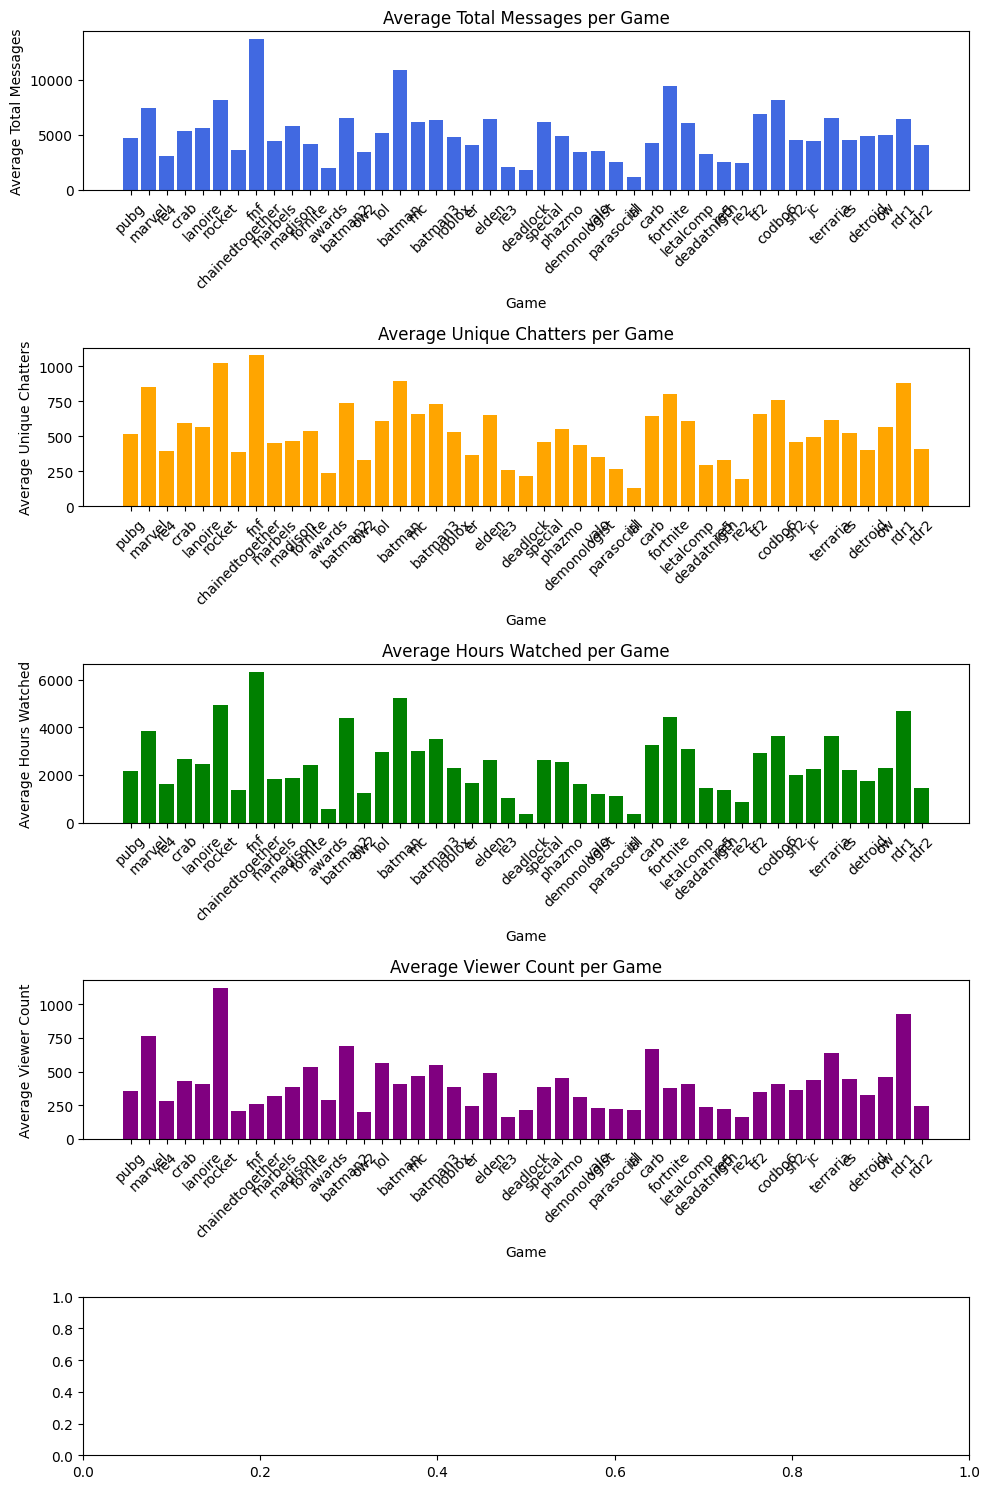

In [77]:
# Set up the figure and axes for subplots
fig, ax = plt.subplots(5, 1, figsize=(10, 15))

# Bar chart for Average Total Messages
ax[0].bar(game_impact_df['Game'], game_impact_df['Average Total Messages'], color='royalblue')
ax[0].set_title('Average Total Messages per Game')
ax[0].set_xlabel('Game')
ax[0].set_ylabel('Average Total Messages')
ax[0].tick_params(axis='x', rotation=45)

# Bar chart for Average Unique Chatters
ax[1].bar(game_impact_df['Game'], game_impact_df['Average Unique Chatters'], color='orange')
ax[1].set_title('Average Unique Chatters per Game')
ax[1].set_xlabel('Game')
ax[1].set_ylabel('Average Unique Chatters')
ax[1].tick_params(axis='x', rotation=45)

# Bar chart for Average Hours Watched
ax[2].bar(game_impact_df['Game'], game_impact_df['Average Hours Watched'], color='green')
ax[2].set_title('Average Hours Watched per Game')
ax[2].set_xlabel('Game')
ax[2].set_ylabel('Average Hours Watched')
ax[2].tick_params(axis='x', rotation=45)

# Bar chart for Average Hours Watched
ax[3].bar(game_impact_df['Game'], game_impact_df['Average Viewer Count'], color='purple')
ax[3].set_title('Average Viewer Count per Game')
ax[3].set_xlabel('Game')
ax[3].set_ylabel('Average Viewer Count')
ax[3].tick_params(axis='x', rotation=45)


# Adjust layout
plt.tight_layout()
plt.show()


In [78]:
# Extract only the date (without time)
data['date_only'] = data['date'].dt.date

# Group by 'stream' and find the first message date
stream_date = data.groupby('stream')['date_only'].min().reset_index()

# Rename the columns appropriately
stream_date.columns = ['stream', 'stream_date']

# Assuming stream_stats is the existing DataFrame you want to update
# Merge the stream_date with the stream_stats DataFrame
stream_stats = stream_stats.merge(stream_date, on='stream', how='left')

# Now, stream_stats will have a new column 'stream_date' with the date of the first message for each stream.


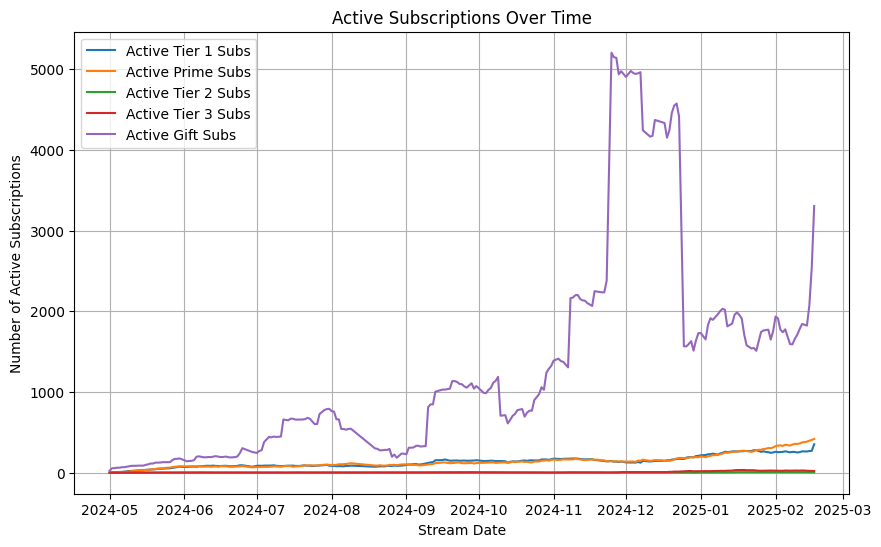

In [79]:
# Convert stream_date to datetime if it is not already
stream_stats['stream_date'] = pd.to_datetime(stream_stats['stream_date'])

# Tier1
active_subs = []

for i in range(len(stream_stats)):
    current_date = stream_stats.iloc[i]['stream_date']
    
    mask = (stream_stats['stream_date'] <= current_date) & \
           (stream_stats['stream_date'] > current_date - pd.Timedelta(days=30))
    active_sub_count = stream_stats.loc[mask, 'tier1'].sum()
    
    active_subs.append(active_sub_count)
stream_stats['active_subs'] = active_subs

# PRIME
active_prime = []

for i in range(len(stream_stats)):
    current_date = stream_stats.iloc[i]['stream_date']
    
    mask = (stream_stats['stream_date'] <= current_date) & \
           (stream_stats['stream_date'] > current_date - pd.Timedelta(days=30))
    active_prime_count = stream_stats.loc[mask, 'prime'].sum()
    
    active_prime.append(active_prime_count)
stream_stats['active_prime'] = active_prime

# Tier2
active_tier2 = []

for i in range(len(stream_stats)):
    current_date = stream_stats.iloc[i]['stream_date']
    
    mask = (stream_stats['stream_date'] <= current_date) & \
           (stream_stats['stream_date'] > current_date - pd.Timedelta(days=30))
    active_tier2_count = stream_stats.loc[mask, 'tier2'].sum()
    
    active_tier2.append(active_tier2_count)
stream_stats['active_tier2'] = active_tier2

# Tier3
active_tier3 = []

for i in range(len(stream_stats)):
    current_date = stream_stats.iloc[i]['stream_date']
    
    mask = (stream_stats['stream_date'] <= current_date) & \
           (stream_stats['stream_date'] > current_date - pd.Timedelta(days=30))
    active_tier3_count = stream_stats.loc[mask, 'tier3'].sum()
    
    active_tier3.append(active_tier3_count)
stream_stats['active_tier3'] = active_tier3

# Tier3
active_gift = []

for i in range(len(stream_stats)):
    current_date = stream_stats.iloc[i]['stream_date']
    
    mask = (stream_stats['stream_date'] <= current_date) & \
           (stream_stats['stream_date'] > current_date - pd.Timedelta(days=30))
    active_gift_count = stream_stats.loc[mask, 'gift'].sum()
    
    active_gift.append(active_gift_count)
stream_stats['active_gift'] = active_gift

# Plot the data
plt.figure(figsize=(10, 6))

# Plot each subscription type with labels
plt.plot(stream_stats['stream_date'], stream_stats['active_subs'], label='Active Tier 1 Subs')
plt.plot(stream_stats['stream_date'], stream_stats['active_prime'], label='Active Prime Subs')
plt.plot(stream_stats['stream_date'], stream_stats['active_tier2'], label='Active Tier 2 Subs')
plt.plot(stream_stats['stream_date'], stream_stats['active_tier3'], label='Active Tier 3 Subs')
plt.plot(stream_stats['stream_date'], stream_stats['active_gift'], label='Active Gift Subs')

# Add title and labels
plt.title('Active Subscriptions Over Time')
plt.xlabel('Stream Date')
plt.ylabel('Number of Active Subscriptions')

# Display grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

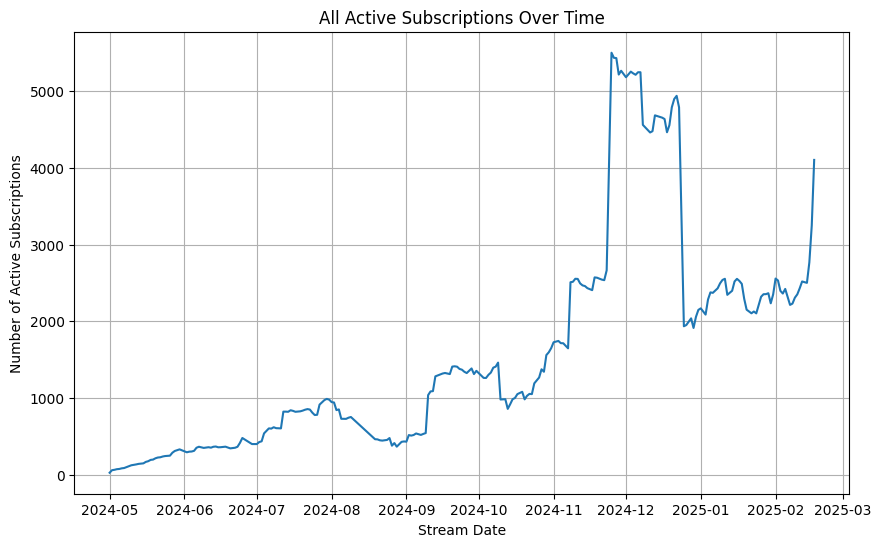

In [80]:
# Calculate the total subs for each stream
stream_stats['all_sub'] = stream_stats['tier1'] + stream_stats['tier2'] + stream_stats['tier3'] + stream_stats['prime'] + stream_stats['gift']

# Initialize a list to store the active subs for each date
active_all_subs = []

# Loop through each date in the dataframe
for i in range(len(stream_stats)):
    current_date = stream_stats.iloc[i]['stream_date']
    
    # Get the total subs in the last 30 days
    mask = (stream_stats['stream_date'] <= current_date) & \
           (stream_stats['stream_date'] > current_date - pd.Timedelta(days=30))
    active_sub_count = stream_stats.loc[mask, 'all_sub'].sum()
    
    active_all_subs.append(active_sub_count)

# Add this new series to the original dataframe
stream_stats['all_active_subs'] = active_all_subs

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(stream_stats['stream_date'], stream_stats['all_active_subs'])
plt.title('All Active Subscriptions Over Time')
plt.xlabel('Stream Date')
plt.ylabel('Number of Active Subscriptions')
plt.grid(True)
plt.show()

In [81]:
stream_stats['ad_rev'] = stream_stats['hours_watched'] * 0.4 / 100

stream_stats['ad_rev']

0        2.536570
1        3.011458
2        2.680580
3        2.578870
4        3.080702
          ...    
239     17.522853
240     22.607130
241     18.923620
242     57.968856
243    225.597330
Name: ad_rev, Length: 244, dtype: float64

In [82]:
stream_stats.tail(3)

,stream,first_messages,total_messages,unique_chatters,message_count,stream_length,stream_length_hour,stream_length_per_firt,unique_chatters_per_hour,message_per_min,...,rdr2,stream_date,active_subs,active_prime,active_tier2,active_tier3,active_gift,all_sub,all_active_subs,ad_rev
241,241,318,7453,1003,7453,15726.0,4.368333,72.796643,229.607020,28.435712,...,0,2025-02-15,269.0,397.0,5.0,23.0,2074.0,314.0,2768.0,18.923620
242,242,792,8029,1469,8029,13894.0,3.859444,205.210882,380.624730,34.672521,...,0,2025-02-16,271.0,406.0,5.0,23.0,2544.0,508.0,3249.0,57.968856
243,243,2936,21031,4257,21031,17367.0,4.824167,608.602522,882.432199,72.658490,...,0,2025-02-17,353.0,418.0,5.0,21.0,3304.0,918.0,4101.0,225.597330


In [83]:
#stream_stats.to_csv('combined_output.csv', index=False)

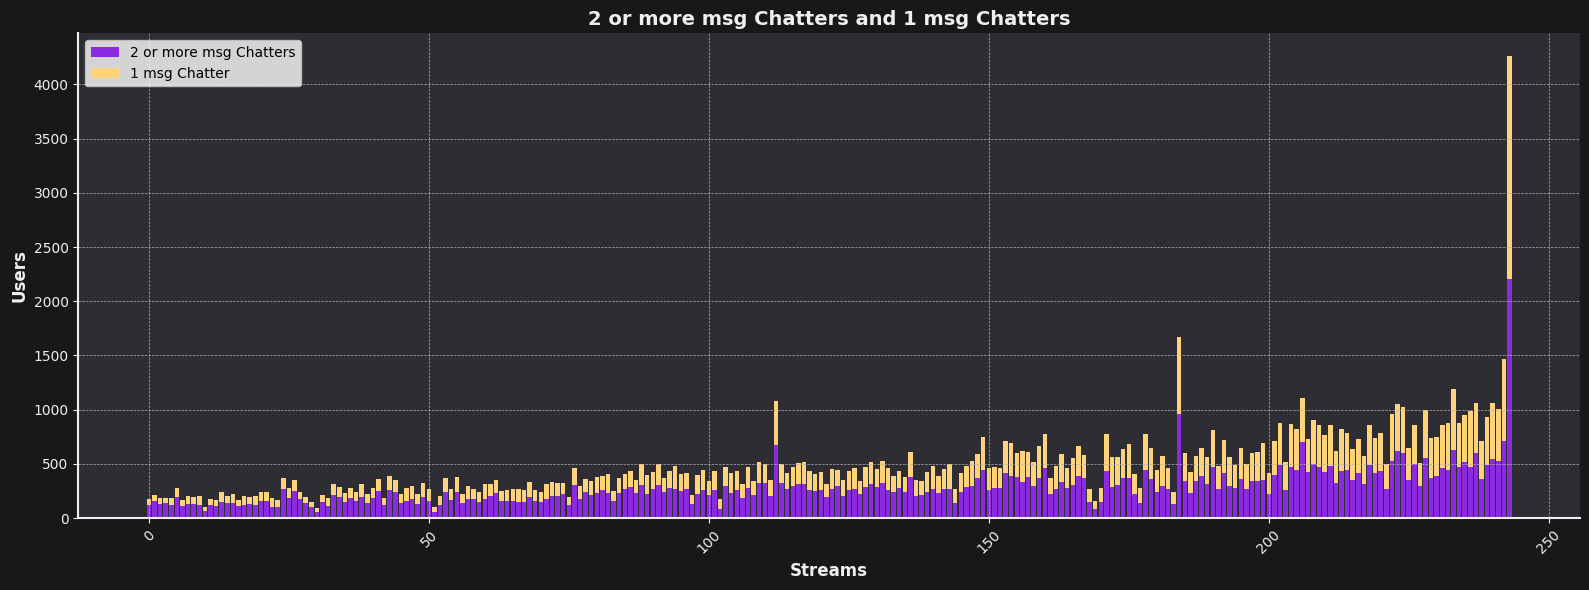

In [84]:
#one_message_user_count
#two_or_more_message_user_counts

# Plot the bars with specified colors
fig, ax = plt.subplots(figsize=(16, 6))  # Set figure size

# Bar plot for all chatters
ax.bar(stream_stats.index, 
       stream_stats['two_or_more_message_user_counts'], 
       label='2 or more msg Chatters',
       edgecolor='none', 
       color='#8A2BE2',  # Custom color for the first set of bars (purple)
      )

# Bar plot for first-time chatters (stacked on top)
ax.bar(stream_stats.index, 
       stream_stats['one_message_user_count'],
       bottom=stream_stats['two_or_more_message_user_counts'],
       label='1 msg Chatter',
       edgecolor='none', 
       color='#FFD37A',  # Custom color for the second set of bars (yellow)
      )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Users', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('2 or more msg Chatters and 1 msg Chatters', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Adding legend to differentiate the bars
ax.legend()

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()


In [85]:
stream_stats['2mgs_per'] = stream_stats['two_or_more_message_user_counts'] / (stream_stats['two_or_more_message_user_counts'] + stream_stats['one_message_user_count']) * 100
stream_stats['1mgs_per'] = 100 - stream_stats['2mgs_per']

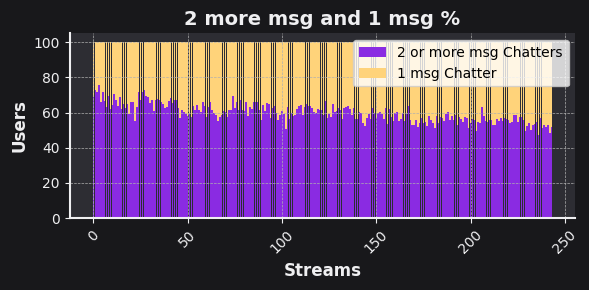

In [86]:
# Plot the bars with specified colors
fig, ax = plt.subplots(figsize=(6, 3))  # Set figure size

# Bar plot for all chatters
ax.bar(stream_stats.index, 
       stream_stats['2mgs_per'], 
       label='2 or more msg Chatters',
       edgecolor='none', 
       color='#8A2BE2',  # Custom color for the first set of bars (purple)
      )

# Bar plot for first-time chatters (stacked on top)
ax.bar(stream_stats.index, 
       stream_stats['1mgs_per'],
       bottom=stream_stats['2mgs_per'],
       label='1 msg Chatter',
       edgecolor='none', 
       color='#FFD37A',  # Custom color for the second set of bars (yellow)
      )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Users', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('2 more msg and 1 msg %', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Adding legend to differentiate the bars
ax.legend()

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()


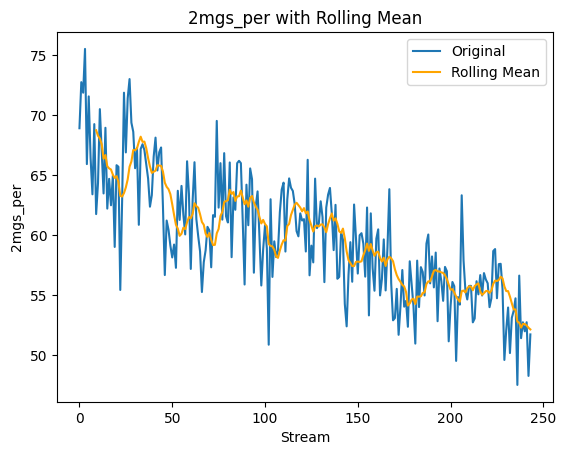

In [87]:
stream_stats['rolling_mean'] = stream_stats['2mgs_per'].rolling(window=10).mean()

plt.plot(stream_stats['stream'], stream_stats['2mgs_per'], label='Original')
plt.plot(stream_stats['stream'], stream_stats['rolling_mean'], label='Rolling Mean', color='orange')
plt.title('2mgs_per with Rolling Mean')
plt.xlabel('Stream')
plt.ylabel('2mgs_per')
plt.legend()
plt.show()


In [88]:
from sklearn.linear_model import LinearRegression

# Assuming 'time' is in datetime format, convert to numerical format
stream_stats['time_ordinal'] = pd.to_datetime(stream_stats['stream_date']).map(pd.Timestamp.toordinal)

X = stream_stats['time_ordinal'].values.reshape(-1, 1)
y = stream_stats['2mgs_per'].values

model = LinearRegression()
model.fit(X, y)

slope = model.coef_[0]

if slope > 0:
    print("The data is trending upwards.")
elif slope < 0:
    print("The data is trending downwards.")
else:
    print("The data is stagnating.")

The data is trending downwards.


In [89]:
import pymannkendall as mk

result = mk.original_test(stream_stats['2mgs_per'])
print(result)

Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-13.329266889333557, Tau=-0.5729946704445794, s=-16987.0, var_s=1623939.0, slope=-0.05681691311852624, intercept=66.47318671778008)


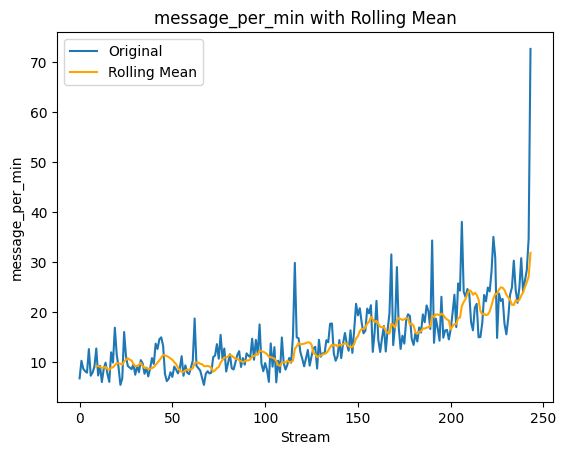

In [90]:
#message_per_min

stream_stats['message_per_min_mean'] = stream_stats['message_per_min'].rolling(window=10).mean()

plt.plot(stream_stats['stream'], stream_stats['message_per_min'], label='Original')
plt.plot(stream_stats['stream'], stream_stats['message_per_min_mean'], label='Rolling Mean', color='orange')
plt.title('message_per_min with Rolling Mean')
plt.xlabel('Stream')
plt.ylabel('message_per_min')
plt.legend()
plt.show()

In [91]:
initial_value = 97068
stream_stats['watch_hour'] = stream_stats['hours_watched'].cumsum() + initial_value

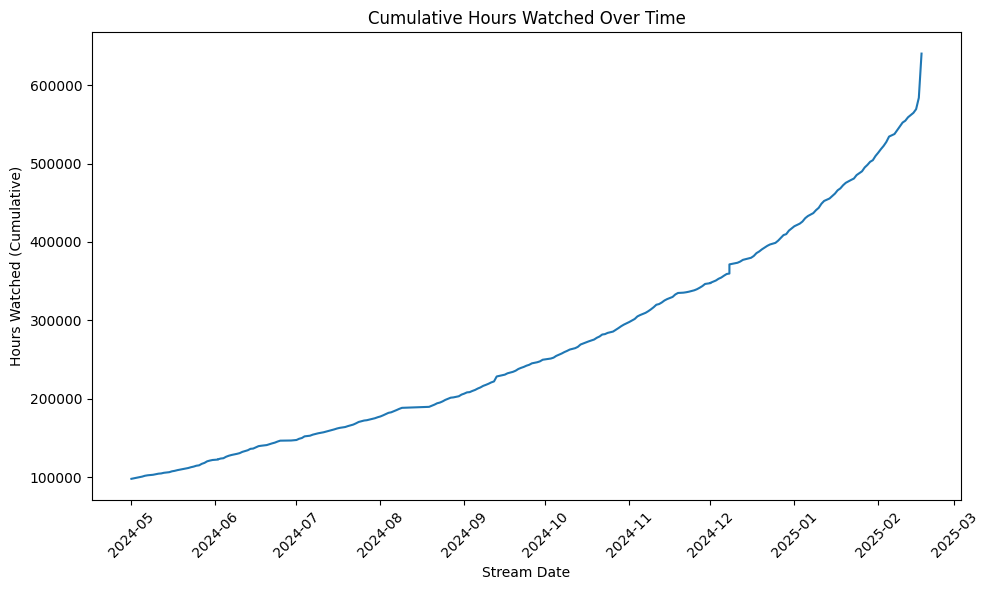

In [92]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(stream_stats['stream_date'], stream_stats['watch_hour'])

# Labels and title
plt.xlabel('Stream Date')
plt.ylabel('Hours Watched (Cumulative)')
plt.title('Cumulative Hours Watched Over Time')

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [93]:
stream_stats['watch_hour'].tail(1)

243    640256.48
Name: watch_hour, dtype: float64

In [94]:
stream_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 98 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   stream                           244 non-null    int64         
 1   first_messages                   244 non-null    int64         
 2   total_messages                   244 non-null    int64         
 3   unique_chatters                  244 non-null    int64         
 4   message_count                    244 non-null    int64         
 5   stream_length                    244 non-null    float64       
 6   stream_length_hour               244 non-null    float64       
 7   stream_length_per_firt           244 non-null    float64       
 8   unique_chatters_per_hour         244 non-null    float64       
 9   message_per_min                  244 non-null    float64       
 10  first_messages_avg               244 non-null    float64      

In [95]:
stream_stats['1mgs_per'].describe()

count    244.000000
mean      40.129195
std        5.182918
min       24.456522
25%       36.606296
50%       40.430068
75%       43.989997
max       52.487310
Name: 1mgs_per, dtype: float64

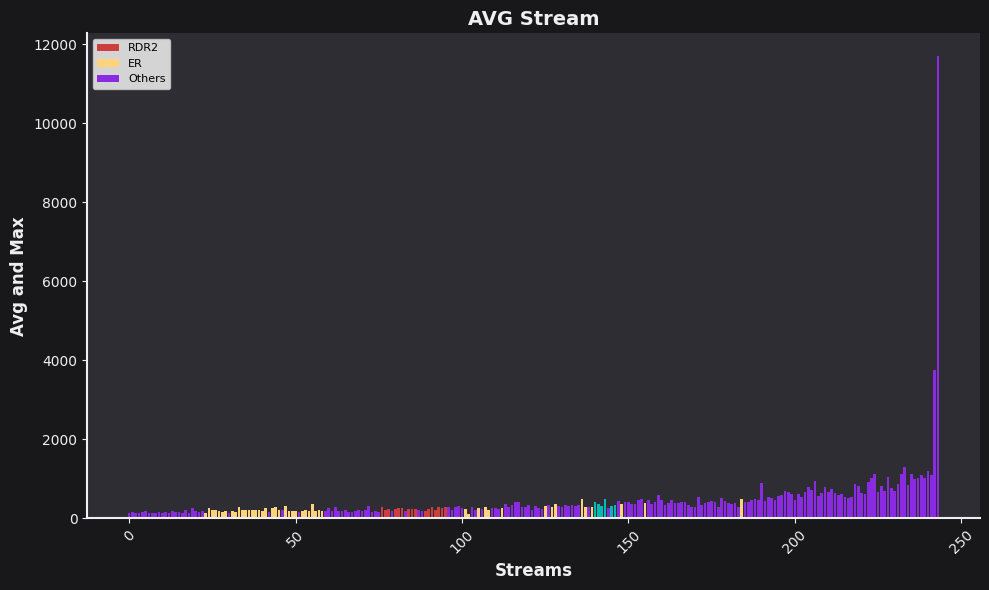

In [96]:
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Create a list of colors based on conditions for each bar
colors = ['#CD3E3E' if sh2 == 1 else '#FFD37A' if rdr2 == 1 else '#00baba' if er == 1 else '#8A2BE2' 
          for sh2,rdr2, er in zip(stream_stats['rdr2'], stream_stats['er'],stream_stats['sh2'])]

# Bar plot with conditional coloring
ax.bar(stream_stats.index, 
       stream_stats['avg'],
       edgecolor='none', 
       color=colors
      )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Avg and Max', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('AVG Stream', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotate x labels
plt.xticks(rotation=45, fontsize=10, color=label_color)

# Customize tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Create custom legend to explain color coding
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#CD3E3E', label='RDR2'),     # Red for 'rdr2 == 1'
    Patch(facecolor='#FFD37A', label='ER'),    # Yellow for 'er == 1'
    Patch(facecolor='#8A2BE2', label='Others')  # Purple for the rest
]
ax.legend(handles=legend_elements, fontsize=8, loc='upper left')

# Adjust layout and display plot
plt.tight_layout()
plt.show()


In [97]:
start_times = data.groupby('stream')['date'].min().reset_index()
start_times.columns = ['stream', 'start_time']
stream_stats = stream_stats.merge(start_times, on='stream', how='left')
#stream_stats['start_time'] = stream_stats['start_time'].dt.strftime('%H:%M')


In [98]:
stream_stats['start_time'].head(10)

0   2024-05-01 17:04:02+02:00
1   2024-05-02 16:54:47+02:00
2   2024-05-03 17:05:42+02:00
3   2024-05-04 17:06:07+02:00
4   2024-05-05 17:03:35+02:00
5   2024-05-06 16:59:55+02:00
6   2024-05-07 16:58:37+02:00
7   2024-05-09 16:56:43+02:00
8   2024-05-10 17:05:15+02:00
9   2024-05-11 20:31:54+02:00
Name: start_time, dtype: datetime64[ns, Europe/Berlin]

In [99]:
# Extract day of the week and hour
stream_stats['day_of_week'] = stream_stats['start_time'].dt.day_name()  # e.g., 'Monday'
stream_stats['hour'] = stream_stats['start_time'].dt.hour  # 0-23

# Group by day of week and hour, then count the occurrences
heatmap_data = stream_stats.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)

# Reorder the days to start from Monday
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(ordered_days)

In [100]:
# Group by day of week and hour, then count the occurrences
heatmap_data = stream_stats.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)

# Reorder the days to start from Monday
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(ordered_days)

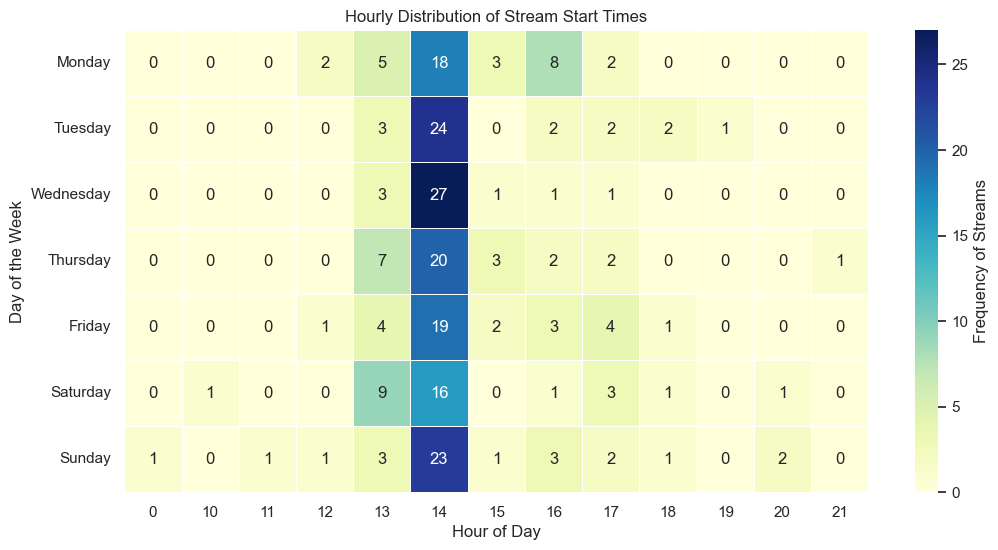

In [101]:
# Set up the figure size and style
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

# Create the heatmap
sns.heatmap(
    heatmap_data, 
    cmap="YlGnBu",   # Color palette (can adjust as needed)
    annot=True,      # Annotate with counts if needed
    fmt="d",         # Format annotations as integers
    linewidths=0.5,  # Line width between cells
    cbar_kws={'label': 'Frequency of Streams'}  # Add color bar label
)

# Add labels and title
plt.xlabel("Hour of Day")
plt.ylabel("Day of the Week")
plt.title("Hourly Distribution of Stream Start Times")
plt.show()

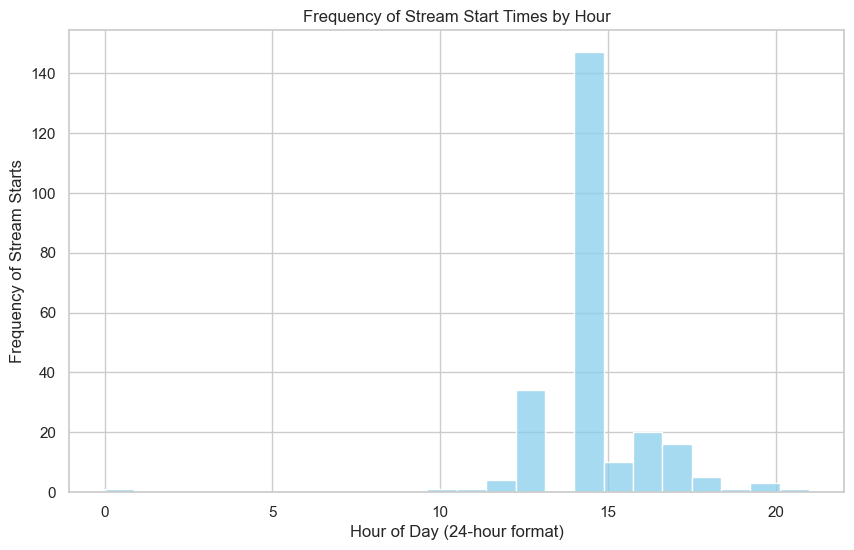

In [102]:
# Set up the figure size
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Create the histogram
sns.histplot(
    stream_stats['hour'], 
    bins=24,              # One bin for each hour (0–23)
    kde=False,            # Disable the KDE (kernel density estimate) line
    color="skyblue"       # Color of the bars
)

# Customize labels and title
plt.xlabel("Hour of Day (24-hour format)")
plt.ylabel("Frequency of Stream Starts")
plt.title("Frequency of Stream Start Times by Hour")

# Show the plot
plt.show()


In [103]:
# Extract the date and hour for plotting
stream_stats['date'] = stream_stats['start_time'].dt.date
stream_stats['hour'] = stream_stats['start_time'].dt.hour + stream_stats['start_time'].dt.minute / 60  # Convert to decimal hour

In [104]:
stream_stats['hour'].head(2)

0    17.066667
1    16.900000
Name: hour, dtype: float64

In [105]:
# Resample to weekly or monthly average start times
weekly_avg_start = stream_stats.resample('W', on='start_time')['hour'].mean()
monthly_avg_start = stream_stats.resample('ME', on='start_time')['hour'].mean()


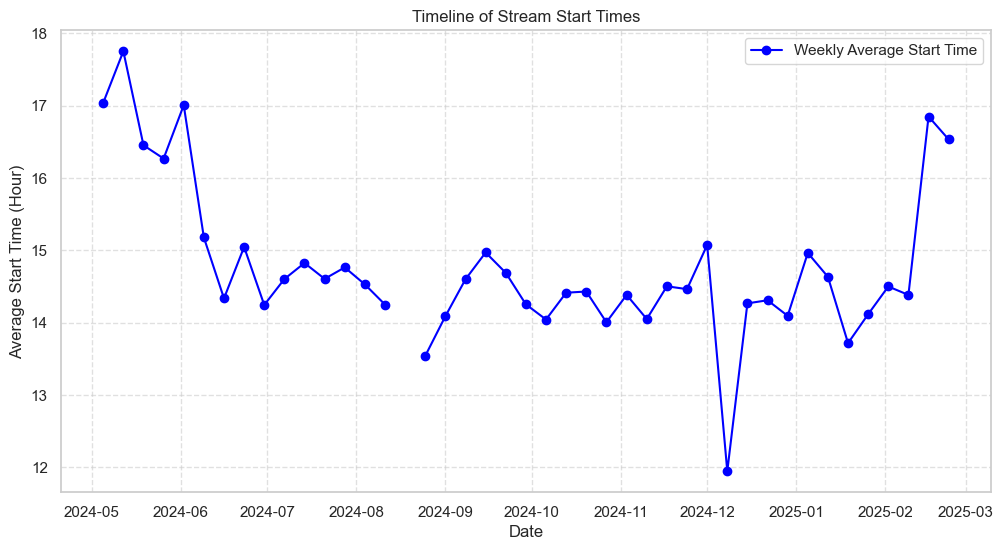

In [106]:
# Set up the figure
plt.figure(figsize=(12, 6))

# Plot the timeline (weekly average in this example)
plt.plot(weekly_avg_start.index, weekly_avg_start, label='Weekly Average Start Time', color='blue', marker='o')

# Customize labels, title, and grid
plt.xlabel("Date")
plt.ylabel("Average Start Time (Hour)")
plt.title("Timeline of Stream Start Times")
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.legend()
plt.show()


In [107]:
# Calculate the points for each stream
stream_stats['stream_points'] = (
    stream_stats['tier1'] * 1 +
    stream_stats['tier2'] * 2 +
    stream_stats['tier3'] * 6
)

# Ensure stream_date is datetime
stream_stats['stream_date'] = pd.to_datetime(stream_stats['stream_date'])

# Extract month and year while preserving year transition
stream_stats['month_year'] = stream_stats['stream_date'].dt.to_period('M')

# Group by month and calculate total points
monthly_points = (stream_stats.groupby('month_year')['stream_points']
                 .sum()
                 .reset_index())

# Rename columns
monthly_points.rename(columns={'stream_points': 'total_monthly_points'}, inplace=True)

# Sort by date to ensure chronological order
monthly_points = monthly_points.sort_values('month_year')

print(monthly_points)

  month_year  total_monthly_points
0    2024-05                  95.0
1    2024-06                  88.0
2    2024-07                 124.0
3    2024-08                 121.0
4    2024-09                 193.0
5    2024-10                 181.0
6    2024-11                 180.0
7    2024-12                 326.0
8    2025-01                 434.0
9    2025-02                 356.0


In [108]:
#stream_stats.to_csv('DorozeaStreamStats.csv', index=False)


In [109]:
stream_stats.tail(2)

,stream,first_messages,total_messages,unique_chatters,message_count,stream_length,stream_length_hour,stream_length_per_firt,unique_chatters_per_hour,message_per_min,...,rolling_mean,time_ordinal,message_per_min_mean,watch_hour,start_time,day_of_week,hour,date,stream_points,month_year
242,242,792,8029,1469,8029,13894.0,3.859444,205.210882,380.624730,34.672521,...,52.282214,739298,27.080462,583857.1475,2025-02-16 16:14:48+01:00,Sunday,16.233333,2025-02-16,14.0,2025-02
243,243,2936,21031,4257,21031,17367.0,4.824167,608.602522,882.432199,72.658490,...,52.143946,739299,31.851195,640256.4800,2025-02-17 16:32:39+01:00,Monday,16.533333,2025-02-17,89.0,2025-02


In [110]:
max_index = stream_stats['message_per_min'].idxmax()
max_stream = stream_stats.loc[max_index, ['stream', 'stream_date']]

print(max_stream)

stream                         243
stream_date    2025-02-17 00:00:00
Name: 243, dtype: object


In [111]:
min_index = stream_stats['message_per_min'].idxmin()
min_stream = stream_stats.loc[min_index, ['stream', 'stream_date']]

print(min_stream)

stream                          22
stream_date    2024-05-25 00:00:00
Name: 22, dtype: object


In [112]:
# Group by hour and count messages
hourly_counts = data.groupby(data['date'].dt.floor('h')).size()

# Find the hour with the most messages
max_hour = hourly_counts.idxmax()
max_count = hourly_counts.max()

print(f"The hour with the most messages is {max_hour} with {max_count} messages.")

The hour with the most messages is 2025-02-17 18:00:00+01:00 with 5330 messages.


In [113]:
# Get the top 5 hours with the most messages
top_10 = hourly_counts.nlargest(10)

print("Top 5 hours with the most messages:")
print(top_10)

Top 5 hours with the most messages:
date
2025-02-17 18:00:00+01:00    5330
2025-02-17 20:00:00+01:00    4431
2025-02-17 16:00:00+01:00    3878
2025-02-17 17:00:00+01:00    3578
2025-01-05 14:00:00+01:00    3333
2025-02-17 19:00:00+01:00    3239
2024-11-25 15:00:00+01:00    3211
2024-11-11 22:00:00+01:00    2976
2025-01-22 19:00:00+01:00    2925
2025-02-07 14:00:00+01:00    2656
dtype: int64


In [114]:

# Group by 10-minute intervals
grouped = data.resample('10min', on='date').size()

# Get the top 5 intervals with the most messages
top_5 = grouped.sort_values(ascending=False).head(10)

print("Top 5 intervals with the most messages:")
print(top_5)

Top 5 intervals with the most messages:
date
2025-02-17 20:20:00+01:00    2039
2025-02-17 16:40:00+01:00    1615
2025-02-16 20:00:00+01:00    1472
2024-11-11 22:20:00+01:00    1313
2025-02-17 16:30:00+01:00    1292
2025-01-05 14:20:00+01:00    1127
2025-02-17 18:50:00+01:00    1107
2025-02-17 16:50:00+01:00     971
2024-12-18 18:20:00+01:00     963
2025-01-03 14:20:00+01:00     948
dtype: int64
